### Define functions to pull out subsets of data and to plot expression

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pickle

def getSubDat(cellsMeta, cellsCount,name):
    sampIds = cellsMeta[[subname == name for subname in [samp.split('_')[len(samp.split('_'))-2] for samp in cellsMeta["sample"].values]]]
    getSubDat = cellsCount[["Unnamed: 0"] + [samp for samp in sampIds["cell id"]]].copy()
    for i,normFact in enumerate(sampIds["genic reads"]):
        getSubDat.iloc[:,i+1] = getSubDat.iloc[:,i+1]*(1E6/float(normFact))
    getSubDat.columns = ["gene_id"]+[sampName for sampName in sampIds["sample"]]
    
    return getSubDat.sort_values('gene_id').reset_index(drop=True) 

def pltHtMap(genes,counts,cLabel,maxCts):

    lookAtGenes = counts[counts["gene_id"] == genes["gene_id"][0]]
    for geneNow in range(1,len(genes["gene_id"])):
        lookAtGenes = pd.concat([lookAtGenes,counts[counts["gene_id"] == genes["gene_id"][geneNow]]])
    pc = plt.pcolor(np.log10(lookAtGenes.iloc[:,1:len(lookAtGenes.columns)]+1),vmin=0,vmax=maxCts)
    plt.yticks(np.arange(0.5, len(genes), 1), genes["name"],fontsize = 12)
    plt.xticks(np.arange(0.5, len(lookAtGenes.iloc[:,1:len(lookAtGenes.columns)].columns), 1), lookAtGenes.iloc[:,1:len(lookAtGenes.columns)].columns,rotation = 90,fontsize = 12)
    cbar = plt.colorbar(pc)
    cbar.set_label('log10(' + cLabel + '+1)', rotation=270,size=24)

### Load gene info

In [2]:
glia = pd.read_csv('geneIDs\\glia.csv')

transmitters = pd.read_csv('geneIDs\\transmitters.csv')
receptors = pd.read_csv('geneIDs\\receptors.csv')

VgatedChannels = pd.read_csv('geneIDs\\VgatedChannels.csv')
innexins = pd.read_csv('geneIDs\\innexins.csv')

neuropeptides = pd.read_csv('geneIDs\\neuropeptides.csv')
GPCRs = pd.read_csv('geneIDs\\GPCRs.csv')

NOreceptors = pd.read_csv('geneIDs\\NOreceptors.csv')

### Load RNA Seq data
#### bulk and low cell

In [4]:
# Get the bulk sequencing data from run #1 - D7s, E-PGs, R4ds (dirty line), whole brain
bulkSeq1 = pd.read_csv('data\\summary_FPKM1.txt',delimiter='\t')
# remove extraneous info
del bulkSeq1['length']
del bulkSeq1['transcript_id(s)']
# remove "dirty" R4d data
del bulkSeq1['R_r1']
del bulkSeq1['R_r2']

# Get the bulk sequencing data from run #1 - P-EGs, D7s, P-EN2s, E-PGs
bulkSeq2 = pd.read_csv('data\\summary_FPKM2.txt',delimiter='\t')
# remove extraneous info
del bulkSeq2['length']
del bulkSeq2['transcript_id(s)']
del bulkSeq2['current_symbol']
del bulkSeq2['FBgn']
del bulkSeq2['full_name']
del bulkSeq2['primaryID']
del bulkSeq2['GO_terms']
del bulkSeq2['gene_id']

# Combine the bulk sequencing data into one dataframe
bulkSeq = pd.concat([bulkSeq1, bulkSeq2],axis=1)
bulkSeq = bulkSeq.reindex(sorted(bulkSeq.columns), axis=1)
testList = list(bulkSeq)
testList = [testList[len(testList)-3]] + testList[0:len(testList)-3] +testList[len(testList)-2:len(testList)]
bulkSeq = bulkSeq[testList]

# Get the low cell sequencing data - P-EN2s
PEN2cellsMeta = pd.read_csv('data\\PEN2cells.meta',delimiter='\t')
PEN2cellsCount = pd.read_csv('data\\PEN2cells.count',delimiter='\t')
PEN2s_lowCell = getSubDat(PEN2cellsMeta, PEN2cellsCount,"35c")

# Get the low cell sequencing data - R4ds
RNcellsMeta = pd.read_csv('data\\RNcells.meta',delimiter='\t')
RNcellsCount = pd.read_csv('data\\RNcells.count',delimiter='\t')
RNs_lowCell = getSubDat(RNcellsMeta, RNcellsCount,"SS00238")

# Get the low cell sequencing data - whole brain
WBcellsMeta = pd.read_csv('data\\WBcells.meta',delimiter='\t')
WBcellsCount = pd.read_csv('data\\WBcells.count',delimiter='\t')
wholeBrain = getSubDat(WBcellsMeta, WBcellsCount,"CBqRNA")

# Combine the low cell data into one dataframe
lowCellSeq = pd.concat([PEN2s_lowCell,RNs_lowCell.iloc[:,1:],wholeBrain.iloc[:,1:]], axis=1, join='inner')

#### single cell

In [6]:
import os

# Look at the meta data for each plate
plateMeta = pd.read_csv('data\\platemap.tab',delimiter='\t')

# Load the gene counts and stats for each plate
singleCellSeqFiles = os.listdir('data//files')
geneFiles = []
statsFiles = []
ERCCFiles = []
for fname in singleCellSeqFiles:
    if len(fname.split('_')) > 1:
        if fname.split('_')[1] == 'genes.csv':
            geneFiles = geneFiles + [fname]
        if fname.split('_')[1] == 'stats.csv':
            statsFiles = statsFiles + [fname]
        if fname.split('_')[1] == 'ERCCs.csv':
            ERCCFiles = ERCCFiles + [fname]

allSingleCellData = []
for i,fname in enumerate(geneFiles):
    allSingleCellData = allSingleCellData +[pd.read_csv('data//files//'+fname,delimiter=',')]
    
allSingleCellStats = []
for i,fname in enumerate(statsFiles):
    allSingleCellStats = allSingleCellStats +[pd.read_csv('data//files//'+fname,delimiter=',')]
    
allSingleCellERCCs = []
for i,fname in enumerate(ERCCFiles):
    allSingleCellERCCs = allSingleCellERCCs +[pd.read_csv('data//files//'+fname,delimiter=',')]

#### filter the single cell data by a variety of thresholds and then normalize it

C:\Users\turnerevansd\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


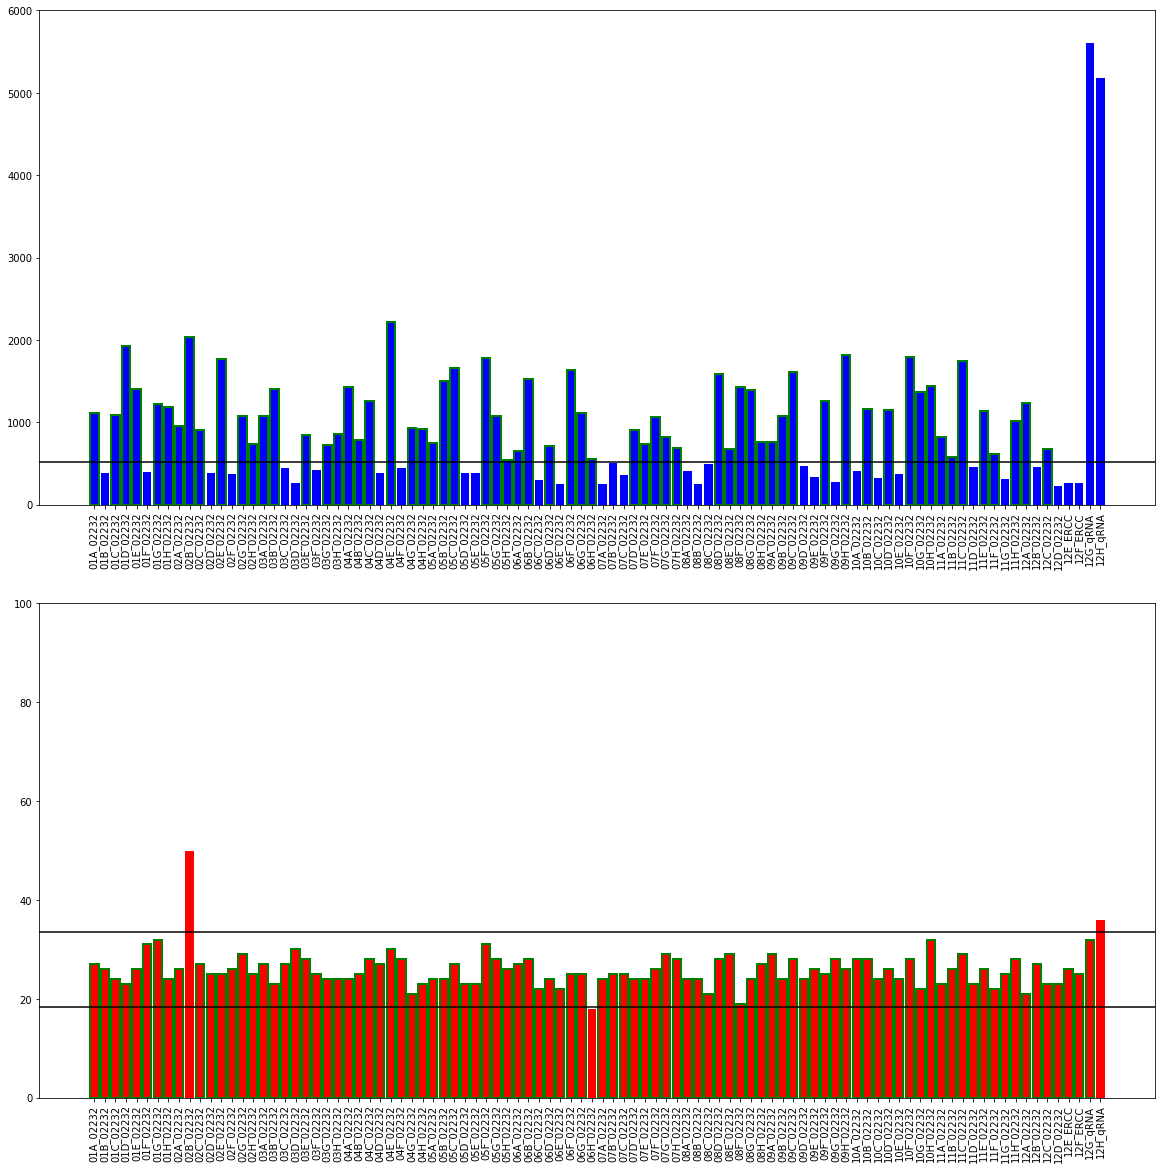

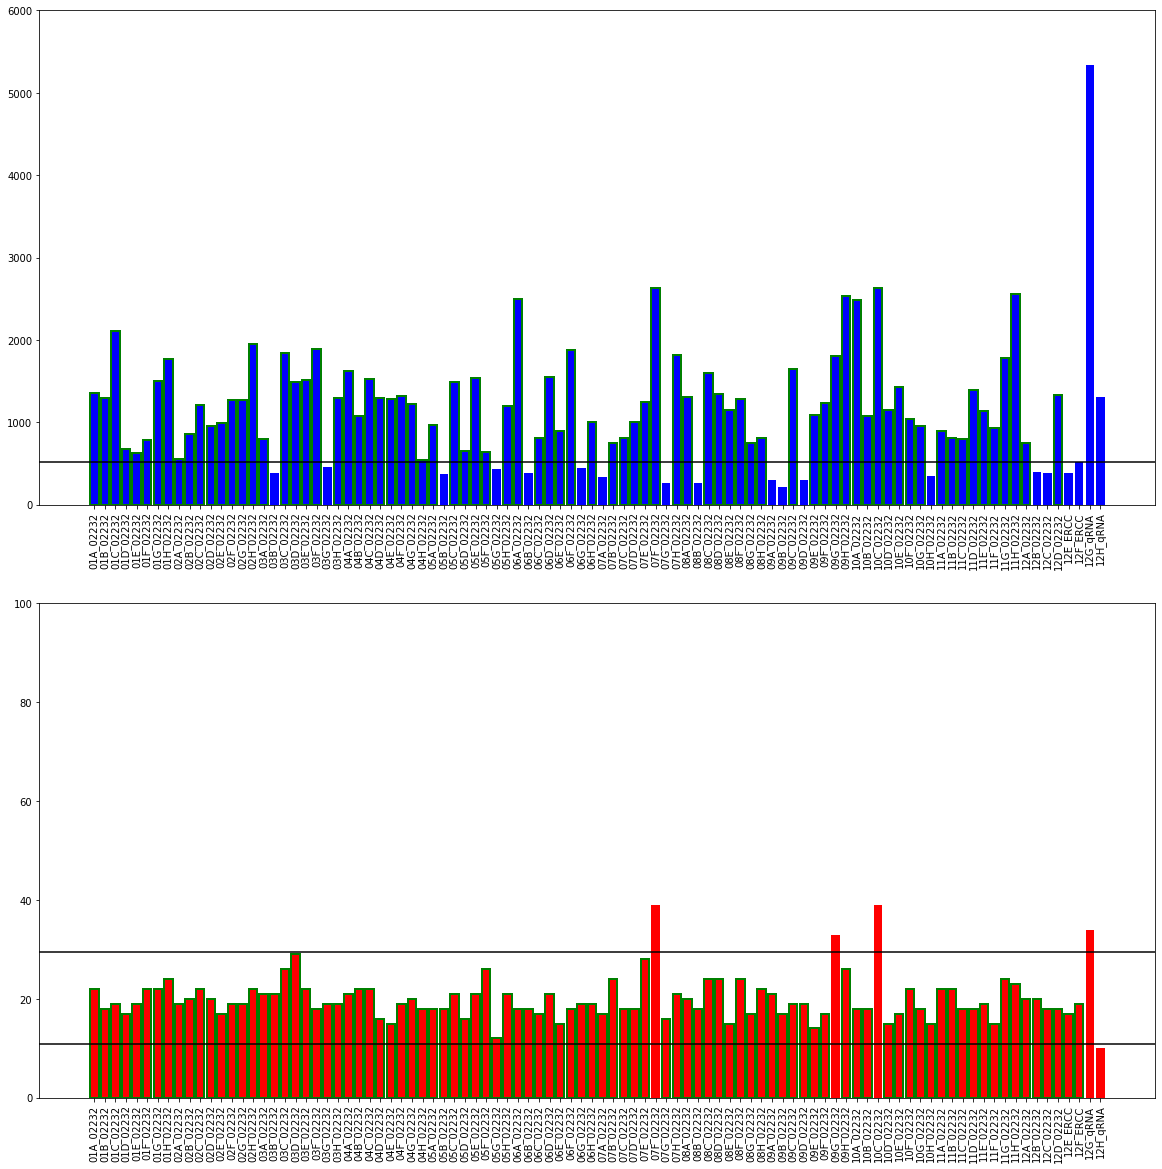

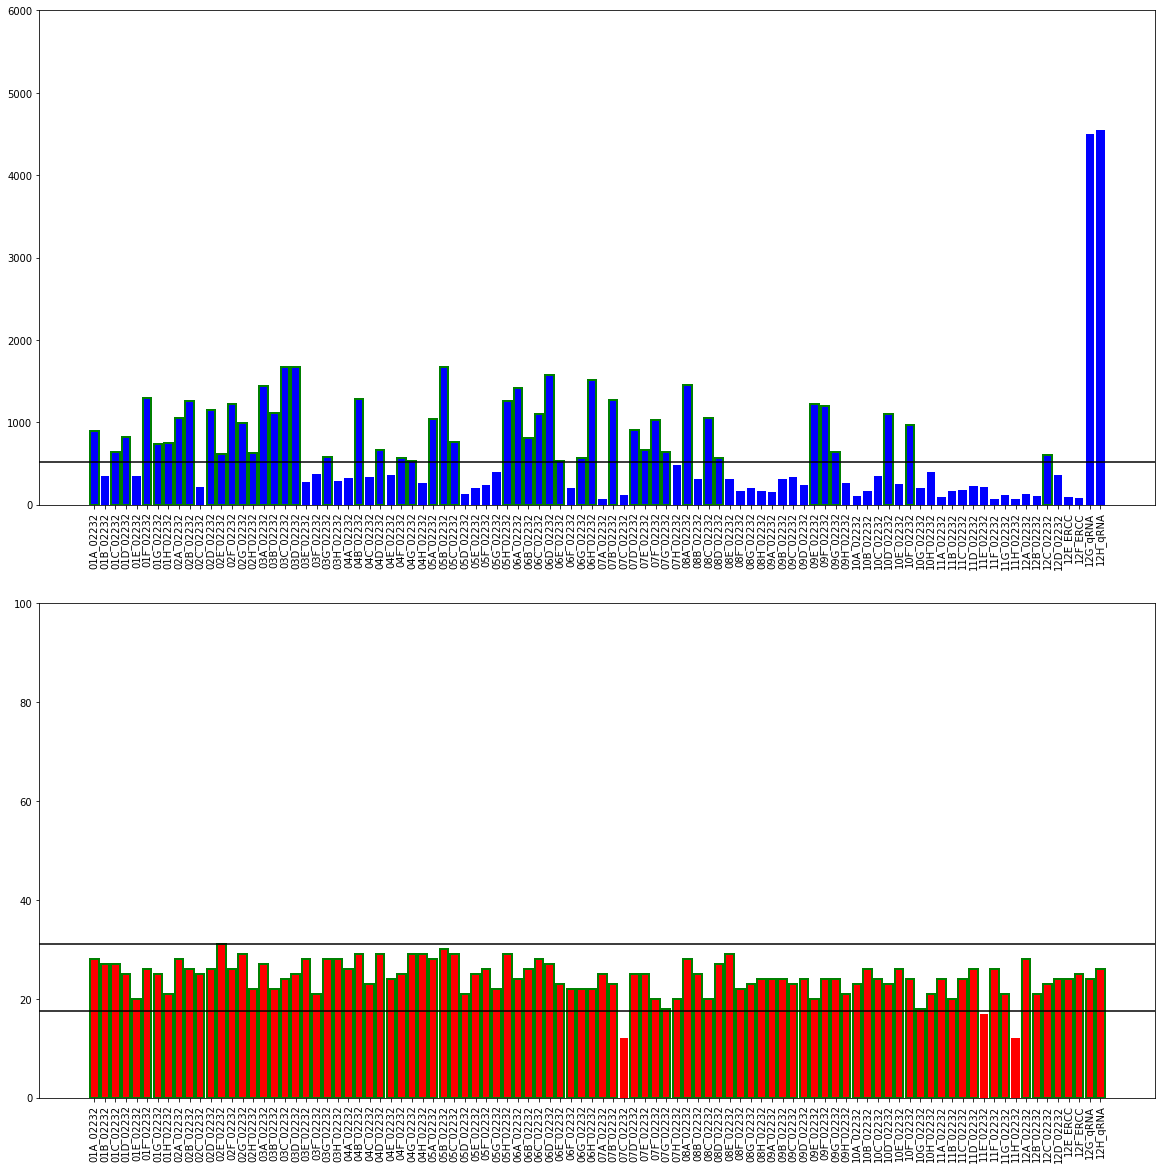

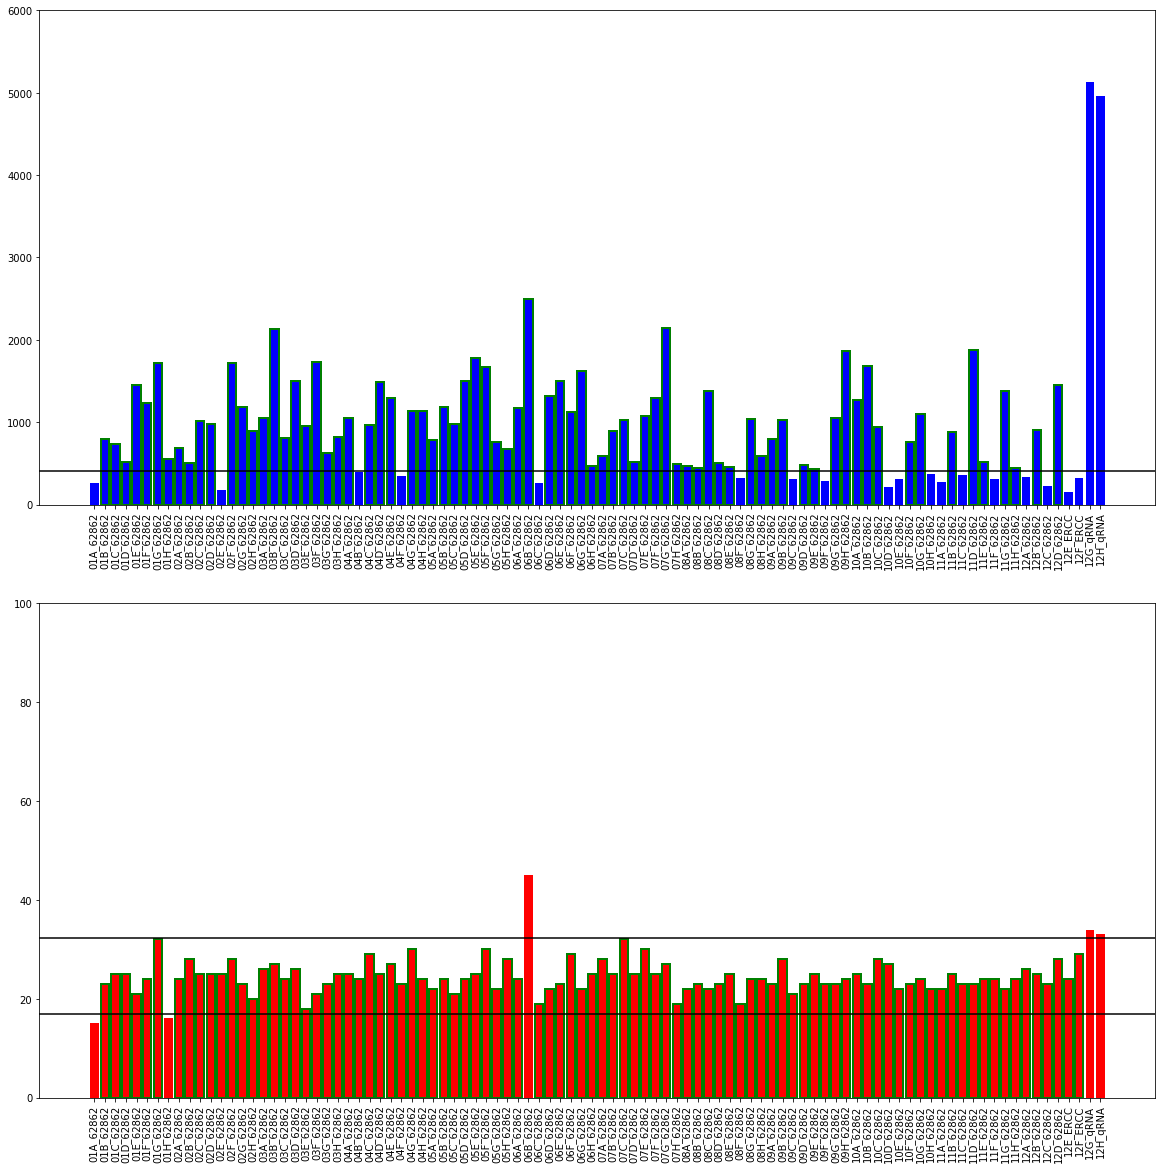

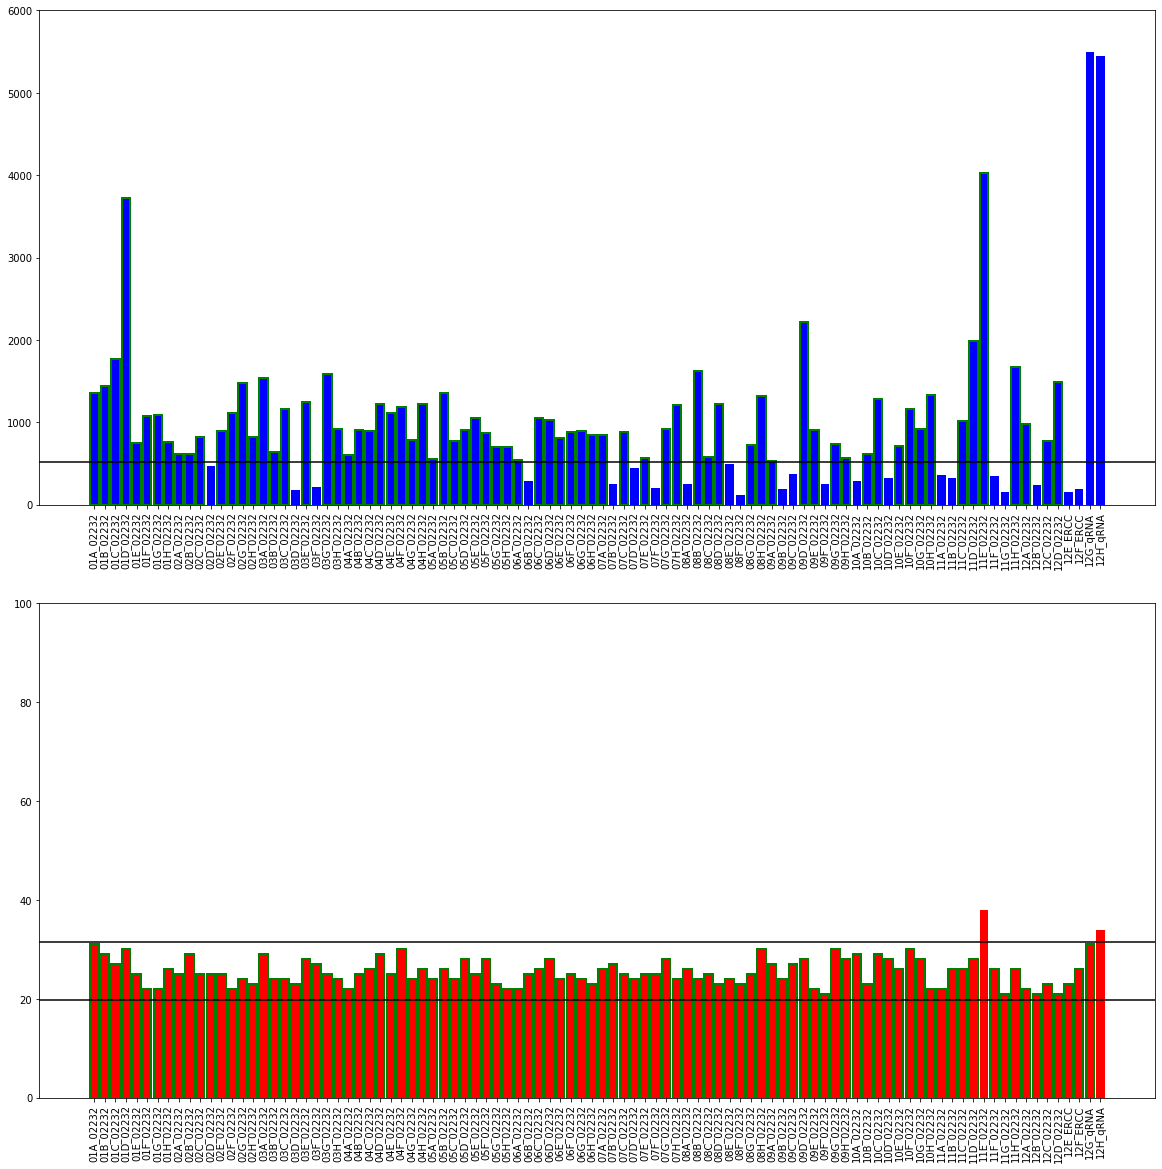

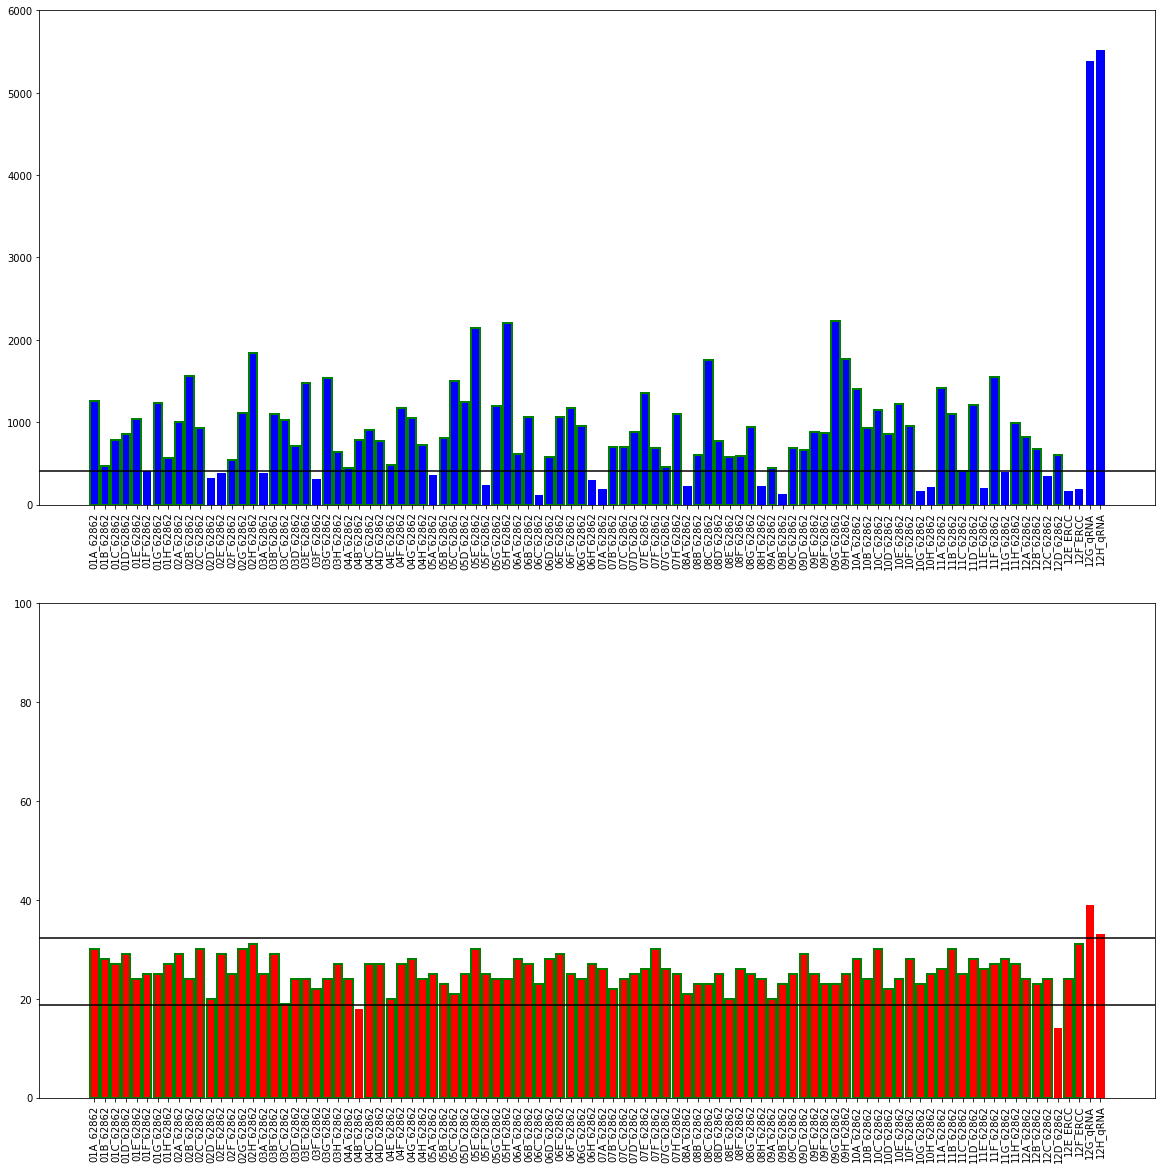

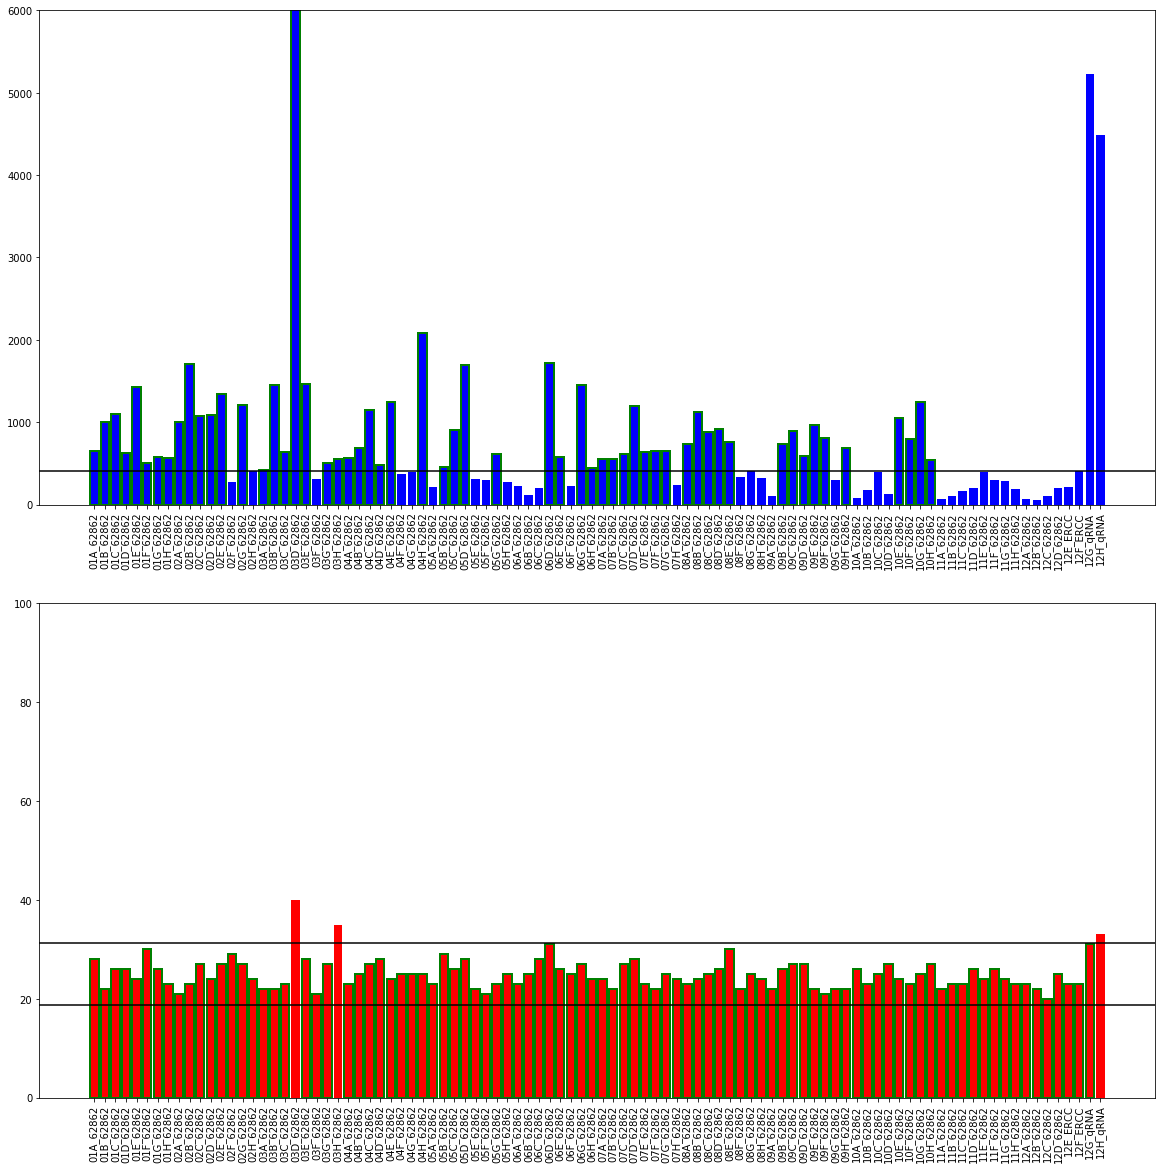

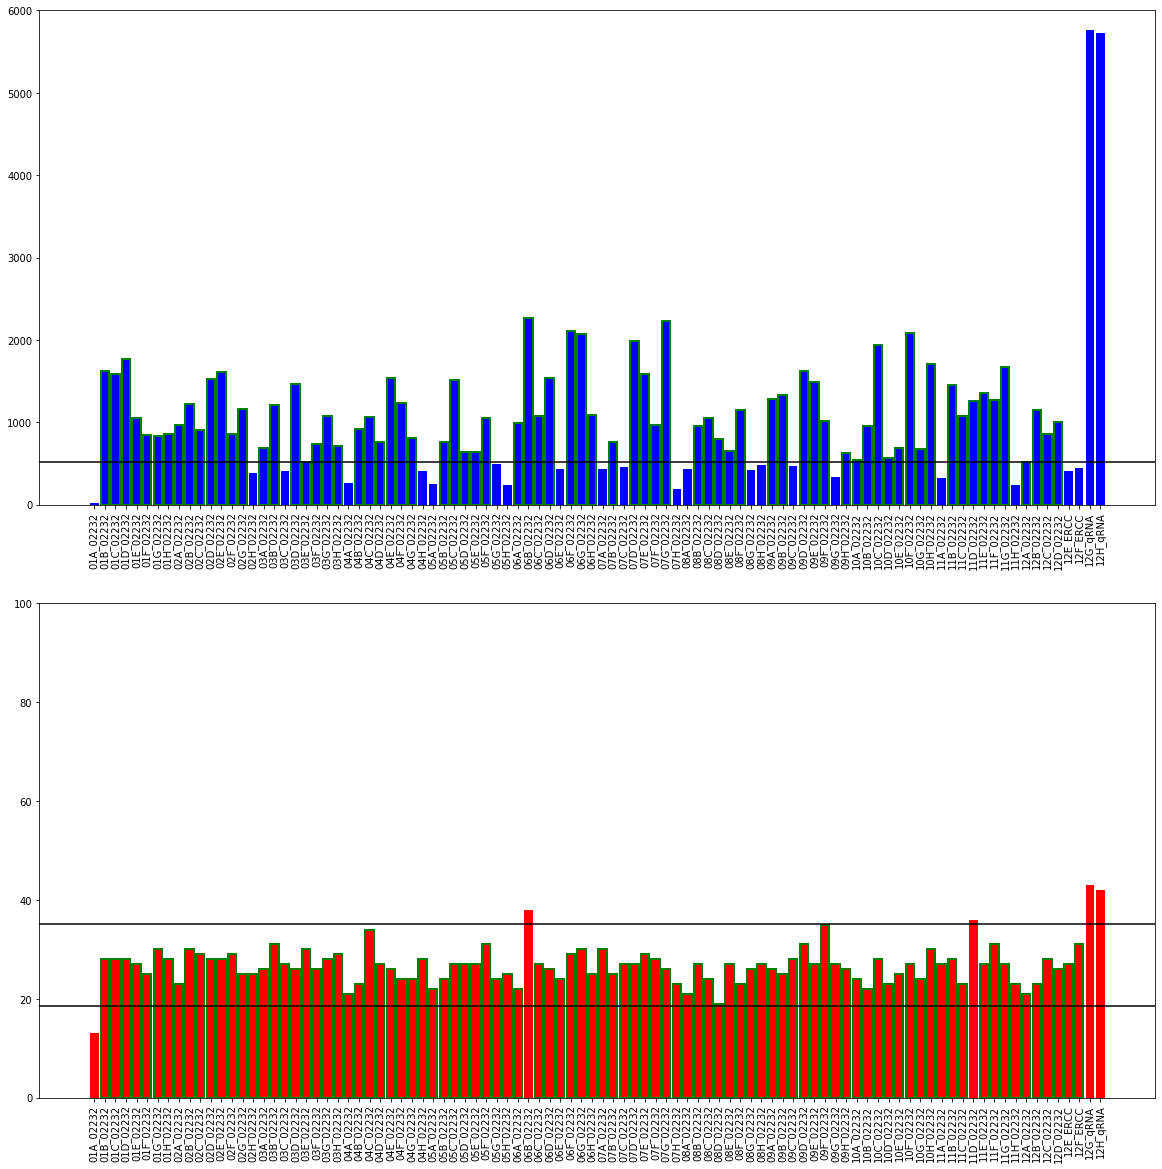

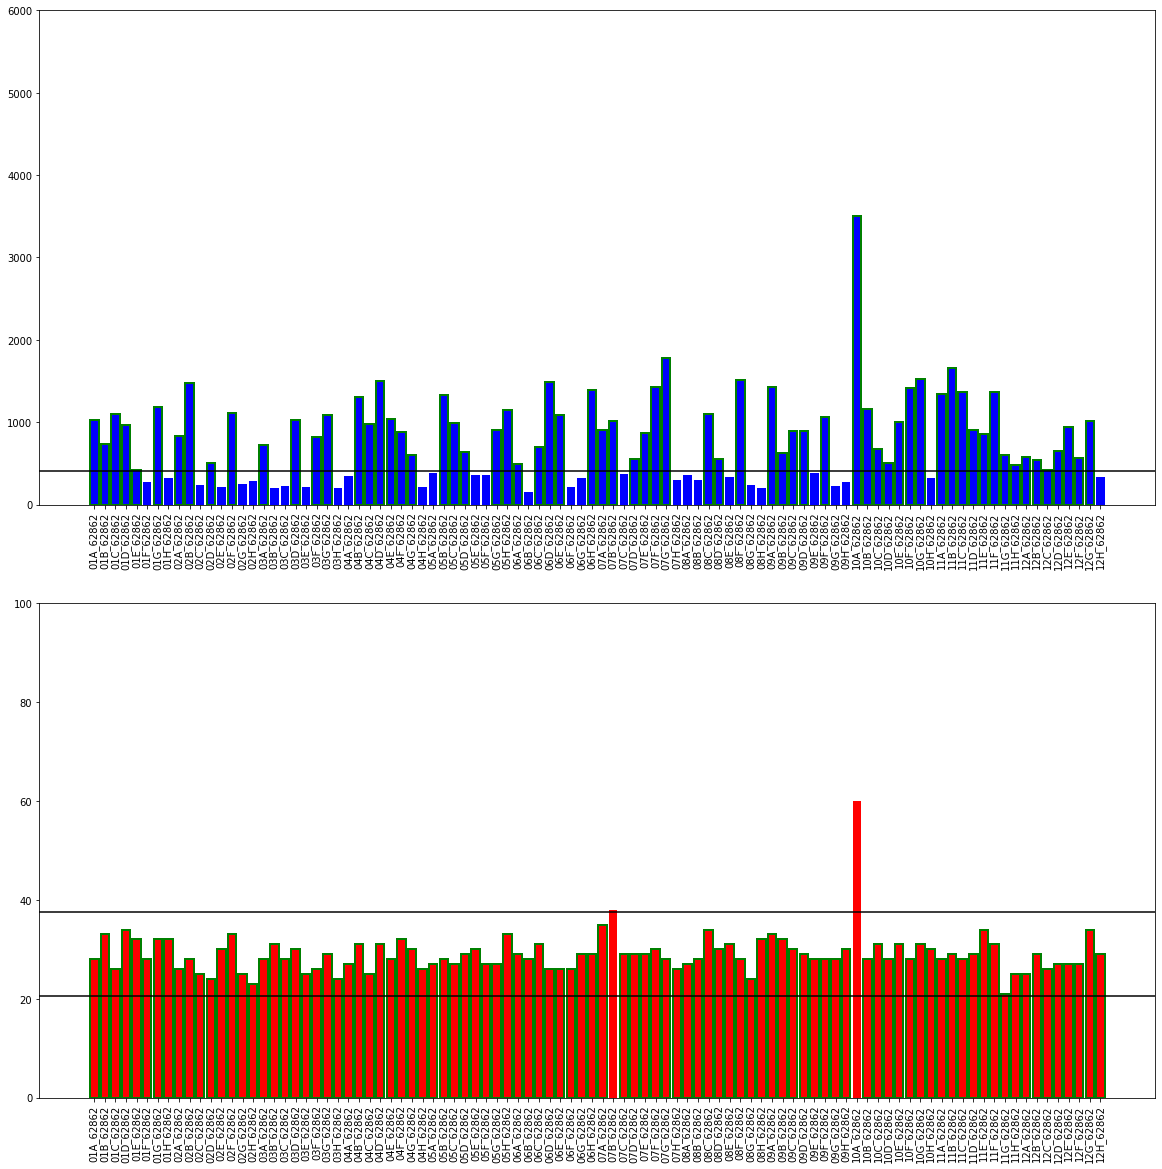

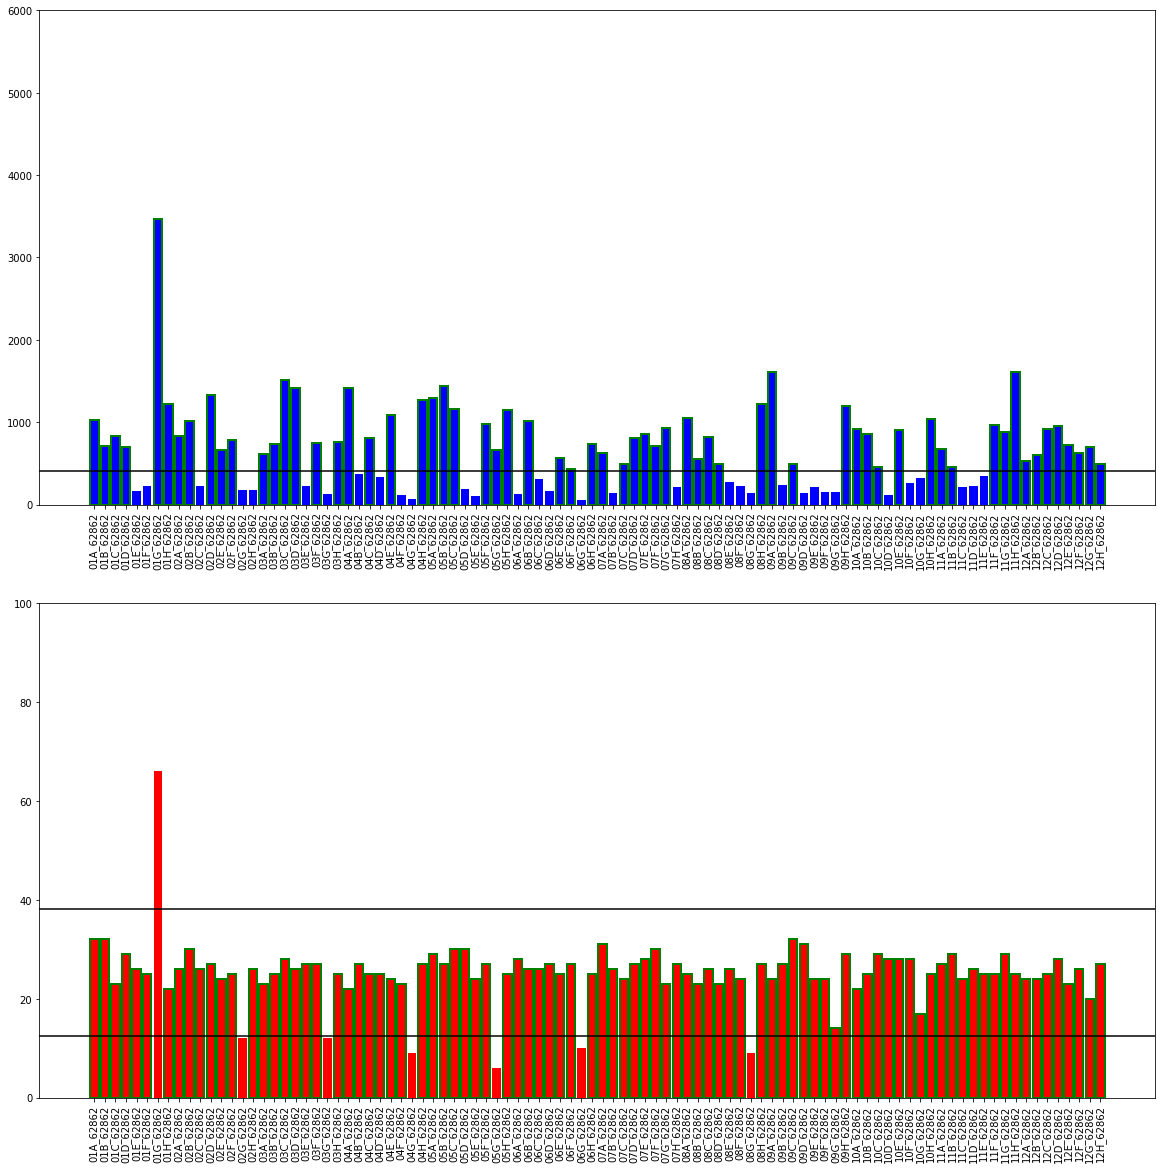

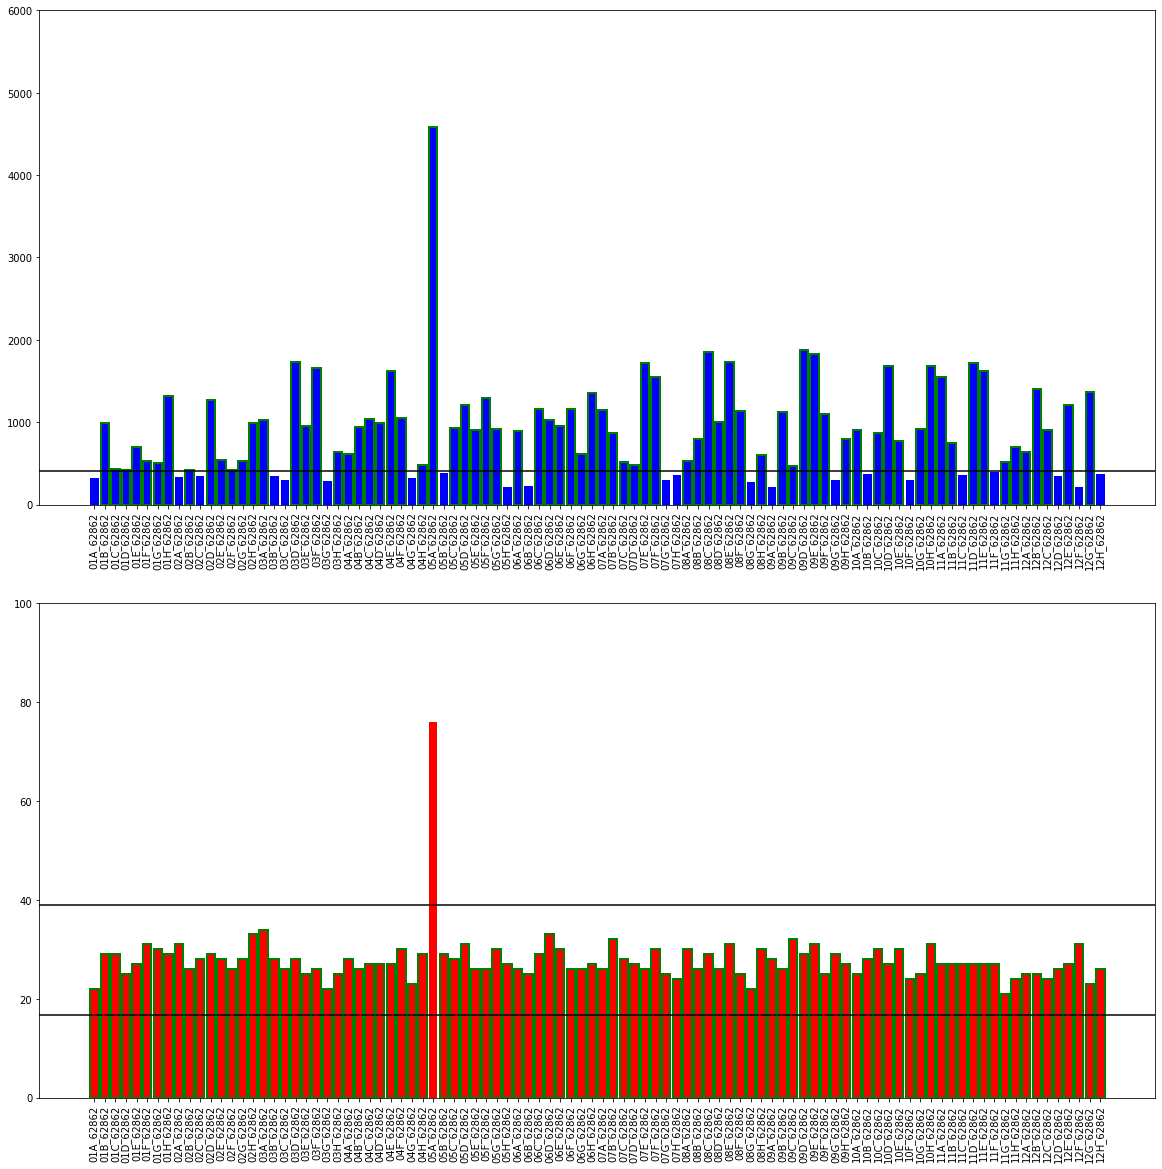

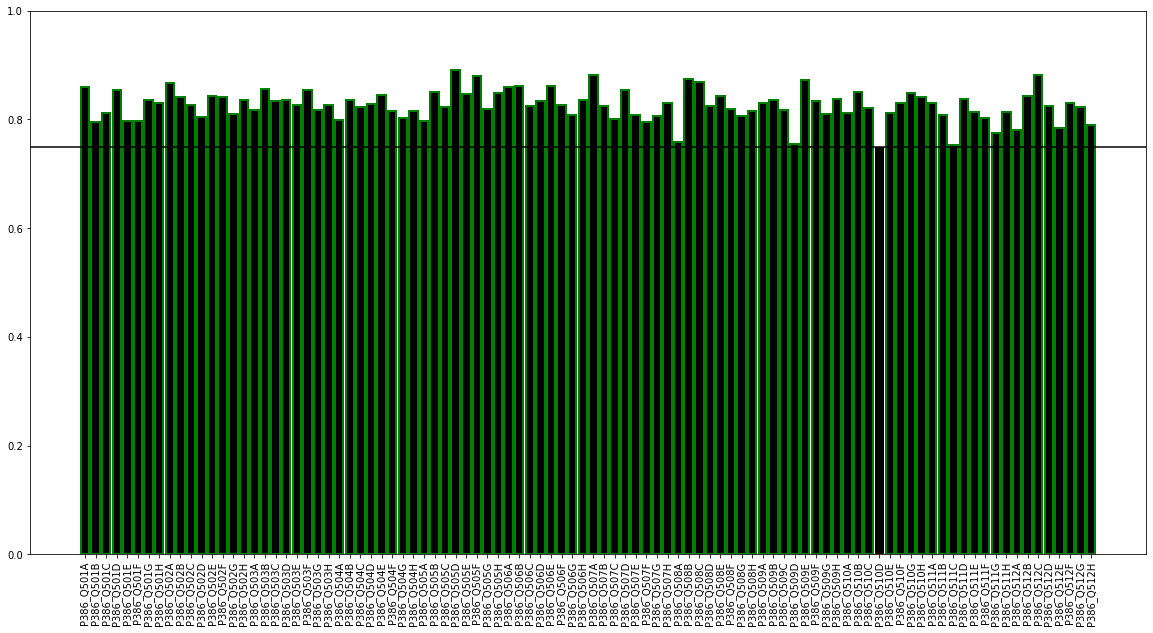

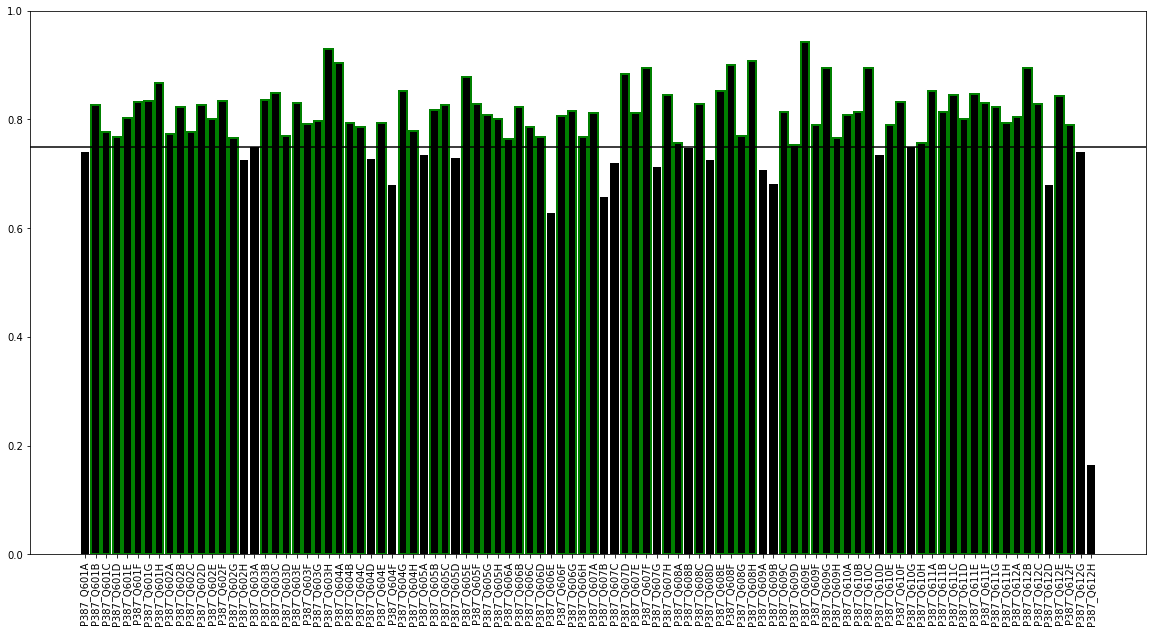

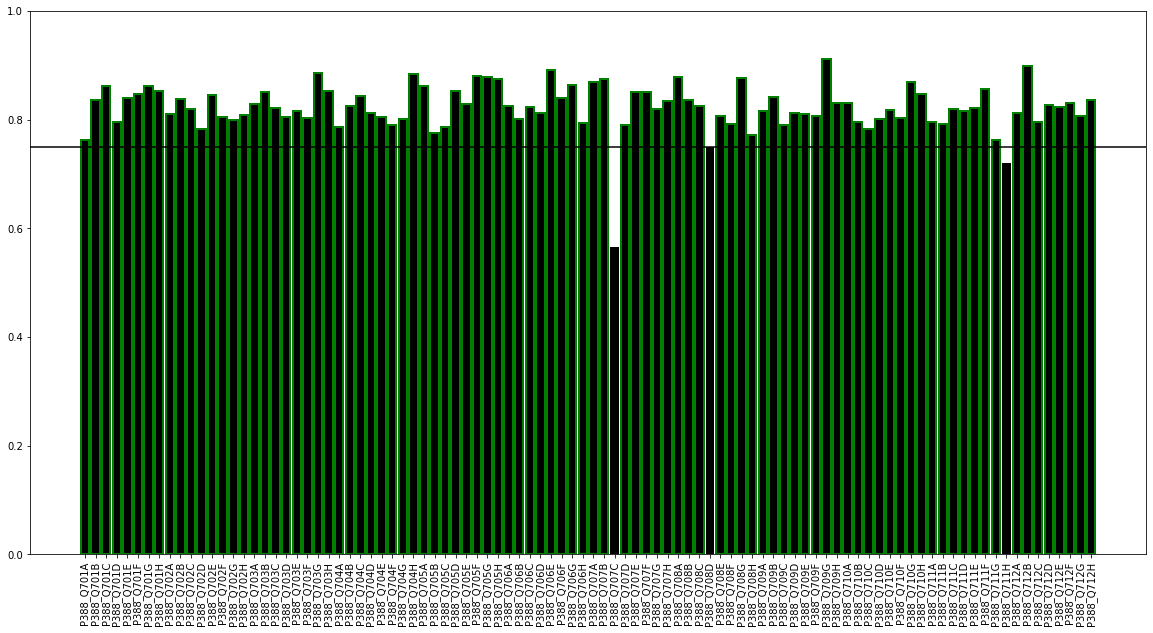

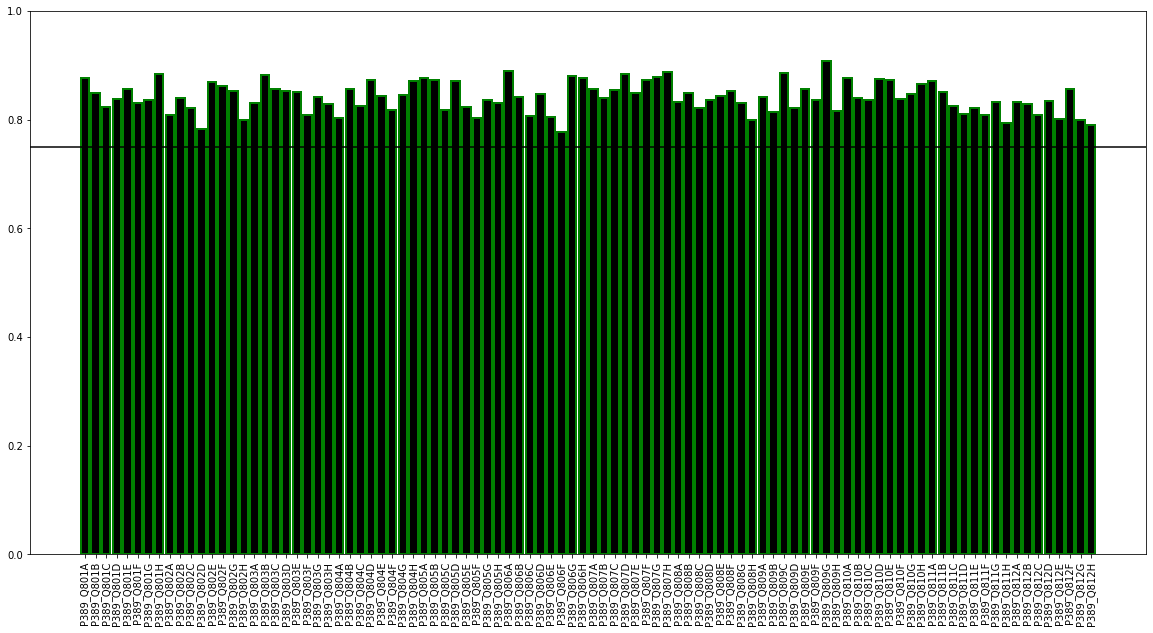

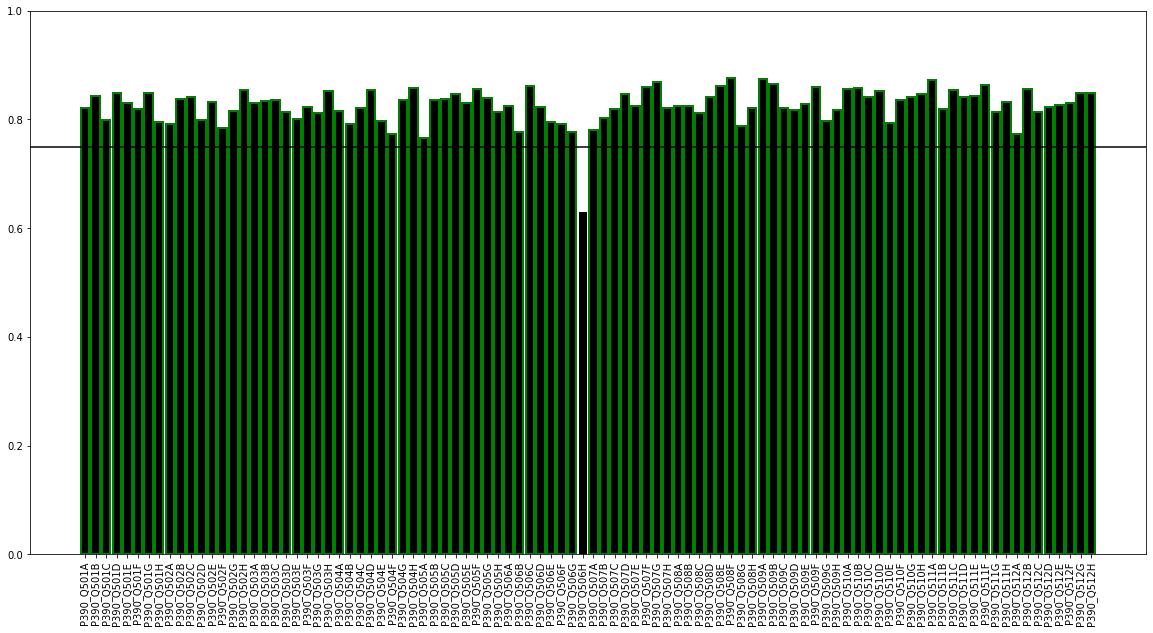

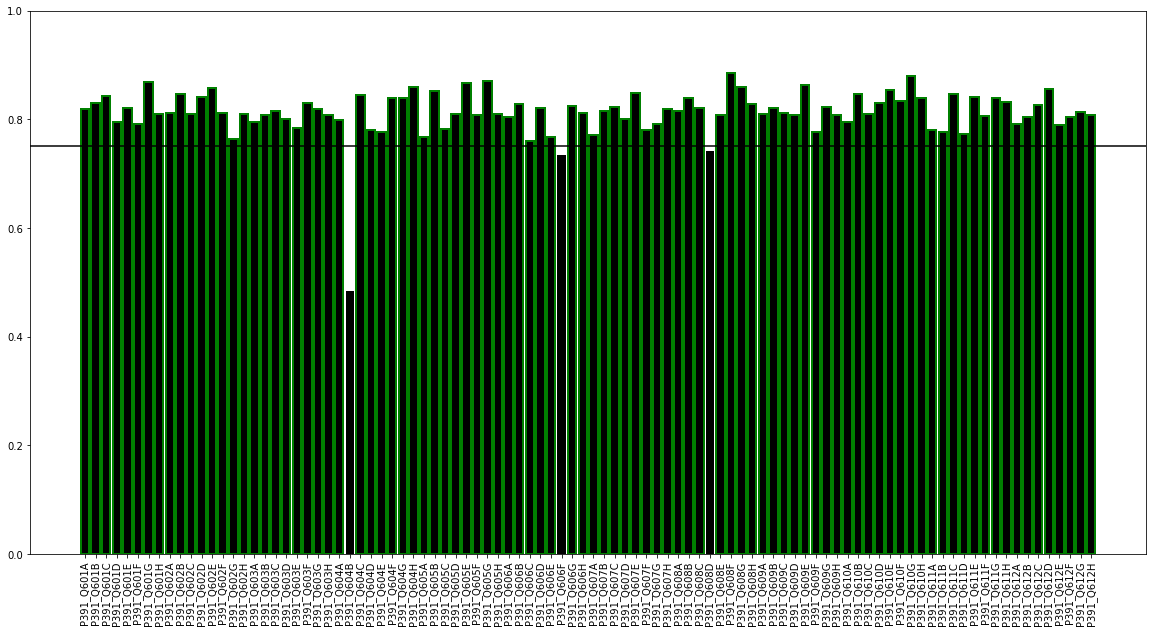

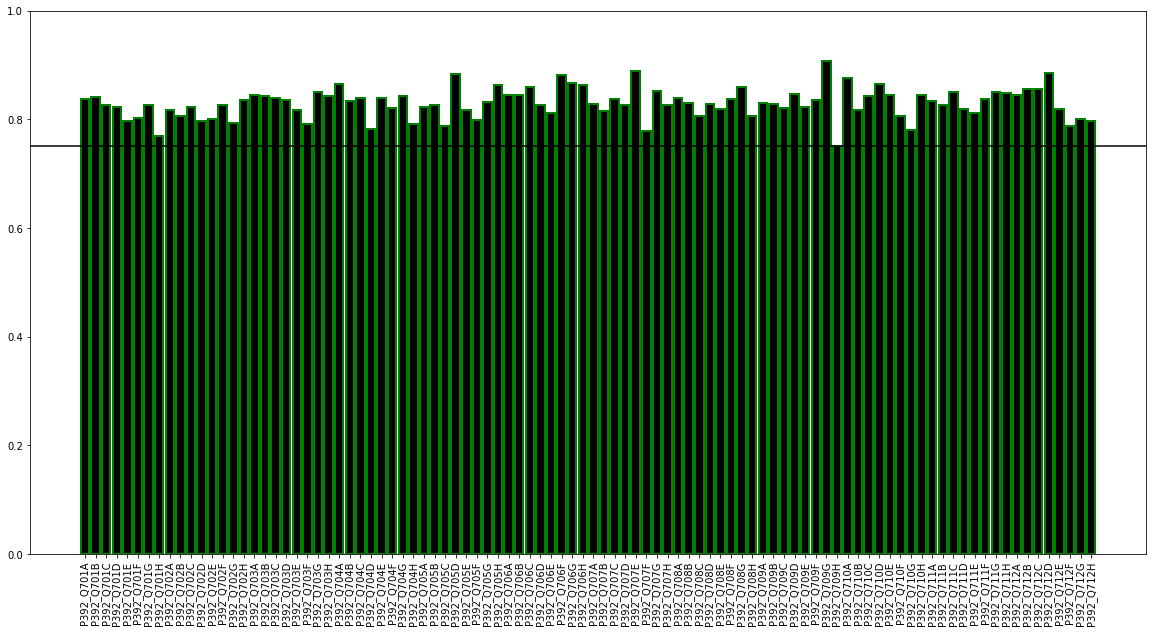

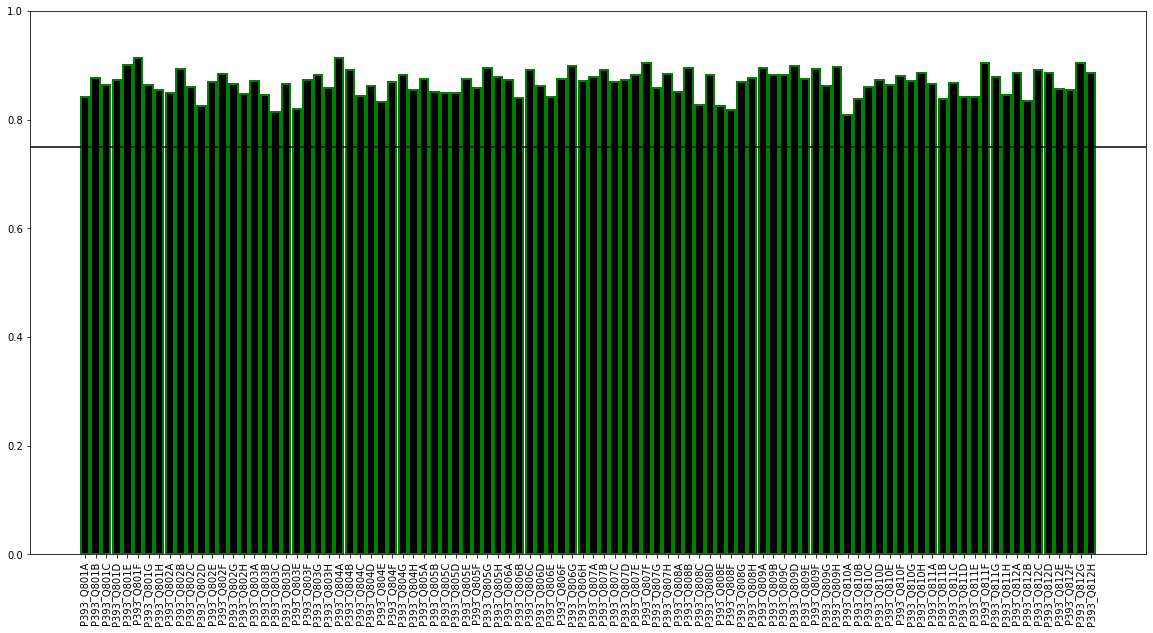

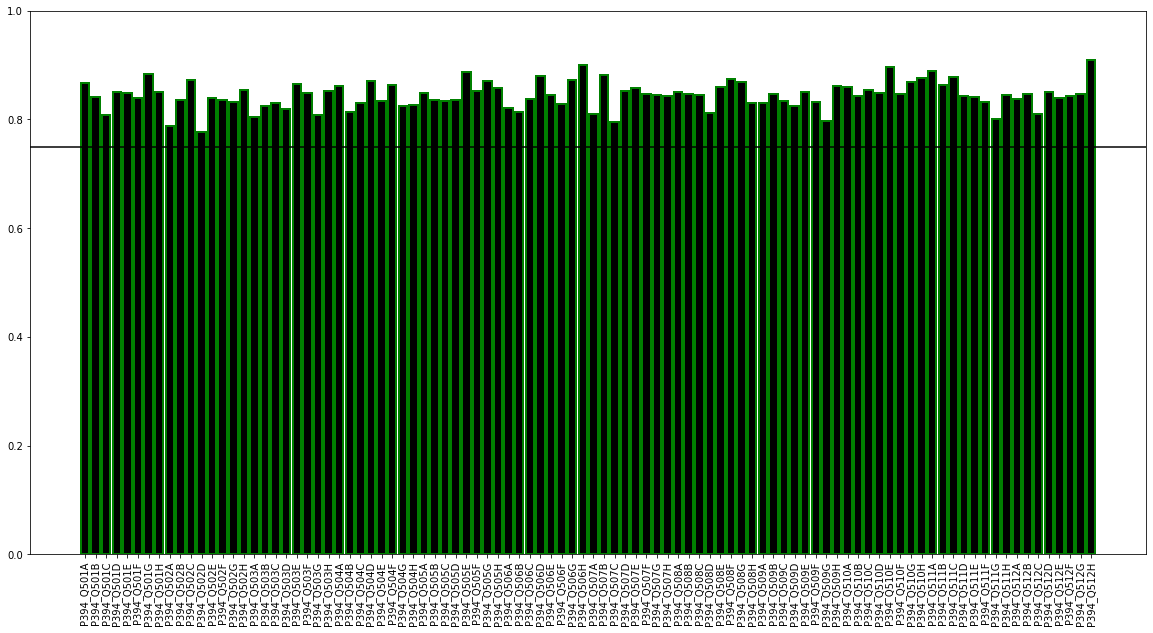

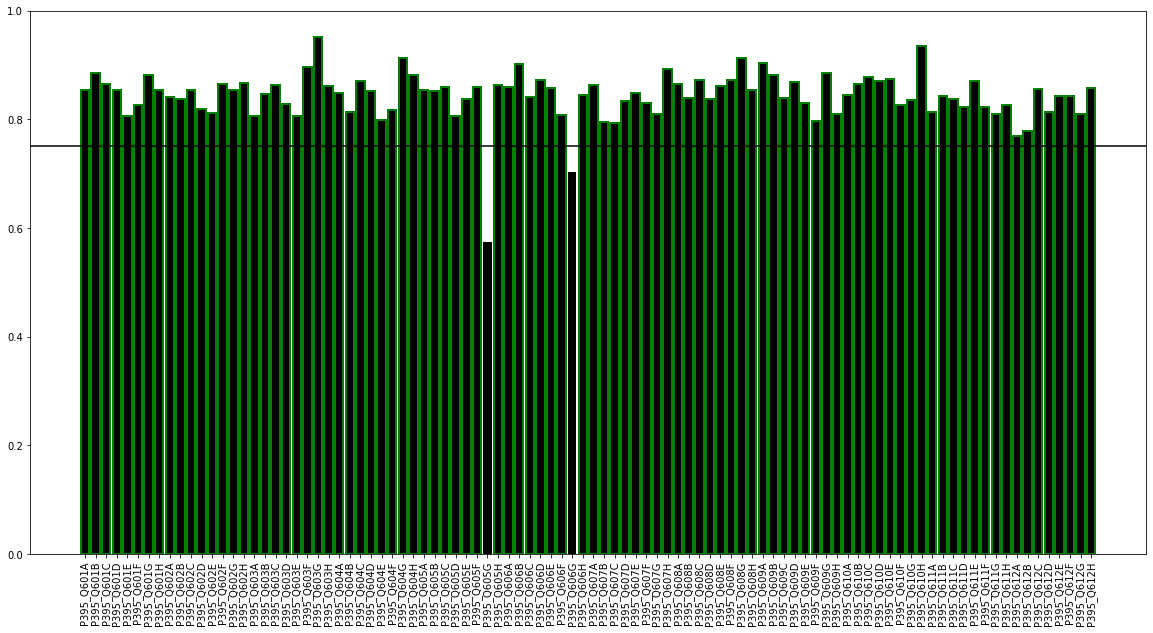

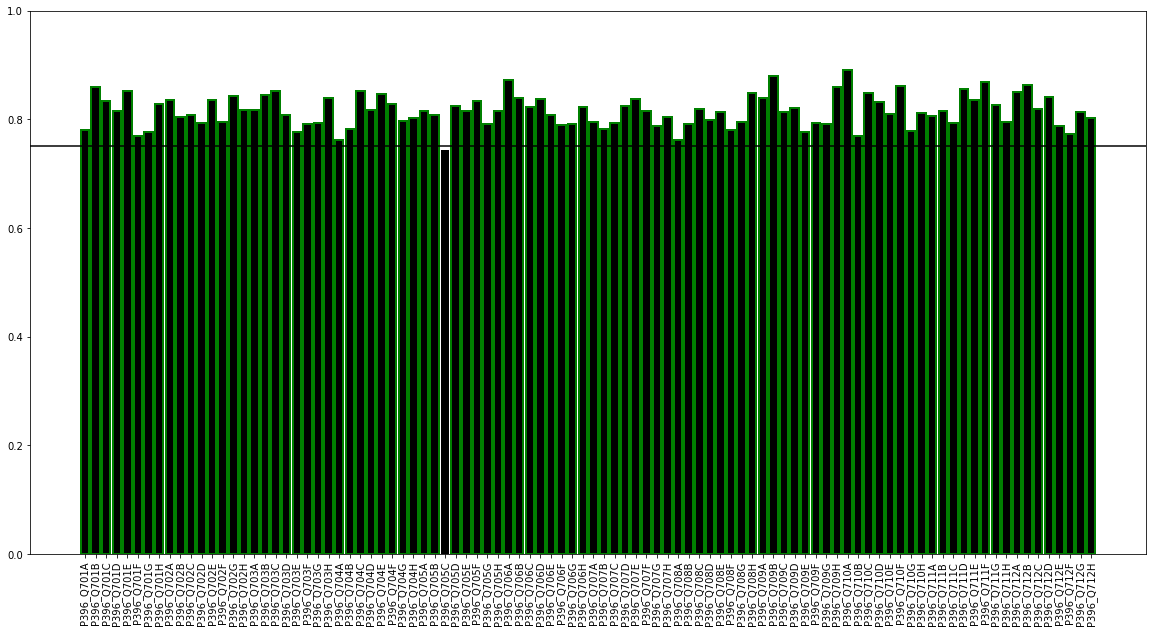

In [15]:
# Plot the single cell stats, discard individual cells that fall outside of the below thresholds, and sort by split line
# Threshold 1: Select the single cells where more genes are detected than in the ERCC alone wells.
# Threshold 2: Select the single cells that are within 2 SD of the mean for number of ERCC genes detected
# Threshold 3: Select the single cells that have a correlation of >0.75 between the ERCC genes counts and the expected # of molecules

# Specify the plate IDs for the two cell types
SS2232Plates = [0,1,2,4,7]
SS62862Plates = [3,5,6,8,9,10]

# Get the number of Drosophila genes found in the ERCC to use as a threshold (do this independently for each split line)
SS2232_ERCCVals = []
SS62862_ERCCVals = []
for plate,indStat in enumerate(allSingleCellStats):
    ERCCInd = [i for i,val in enumerate(indStat['id']) if val.split('_')[1] == 'ERCC']
    if plate in SS2232Plates:
        SS2232_ERCCVals = np.concatenate([SS2232_ERCCVals,indStat['gendet'][ERCCInd].values])
    if plate in SS62862Plates:
        SS62862_ERCCVals = np.concatenate([SS62862_ERCCVals,indStat['gendet'][ERCCInd].values])
        
## Load the expected ERCC copies per reaction
ERCCControls = pd.read_csv('data//ERCC_Controls.csv',delimiter=',')
expectedERCCcts = ERCCControls.sort_values(by='ERCC ID')['copies/ul stock'].values
expectedERCCcts = [int(s.replace(" ","").replace(",","")) for s in expectedERCCcts]

# Plot the ERCC genes detected per well and the total number of genes detected to define thresholds
aboveThreshVals = []
for plate,indStat in enumerate(allSingleCellStats):
    fig = plt.figure(figsize = (20,20))
    
    # The first threshold picks only those wells where the total gene count is higher than the ERCC gene count
    plt.subplot(2,1,1)
    plt.bar(indStat['id'], indStat['gendet'], color = 'b')
    ERCCInd = [i for i,val in enumerate(indStat['id']) if val.split('_')[1] == 'ERCC']
    if plate in SS2232Plates:
        plt.axhline(y=max(SS2232_ERCCVals), color= 'k')
        thresh1 = [i for i,val in enumerate(indStat['gendet']) if val > max(SS2232_ERCCVals)]
    if plate in SS62862Plates:
        plt.axhline(y=max(SS62862_ERCCVals), color= 'k')
        thresh1 = [i for i,val in enumerate(indStat['gendet']) if val > max(SS62862_ERCCVals)]
    ax = plt.gca()
    ax.set_ylim([0, 6e3])
    plt.xticks(rotation=90)
    
    qRNASamps = [i for i,val in enumerate(indStat['id']) if val.split('_')[1]=='qRNA']
    thresh1 = [i for i in thresh1 if i not in qRNASamps]
    plt.bar(indStat['id'][thresh1], indStat['gendet'][thresh1], color = 'none', edgecolor = 'g',linewidth = 2)

    
    # The second threshold discards those cells whose ERCCs are 2 SDs away from the mean
    plt.subplot(2,1,2)
    plt.bar(indStat['id'], indStat['ERCCdet'], color = 'r')
    plt.axhline(y=np.mean(indStat['ERCCdet'])+2*np.std(indStat['ERCCdet']), color= 'k')
    plt.axhline(y=np.mean(indStat['ERCCdet'])-2*np.std(indStat['ERCCdet']), color= 'k')
    ax = plt.gca()
    ax.set_ylim([0, 100])
    plt.xticks(rotation=90)
                                                                              
    thresh2 = [i for i,val in enumerate(indStat['ERCCdet']) if val < np.mean(indStat['ERCCdet'])+2*np.std(indStat['ERCCdet'])]
    thresh3 = [i for i,val in enumerate(indStat['ERCCdet']) if val > np.mean(indStat['ERCCdet'])-2*np.std(indStat['ERCCdet'])]
    thresh2 = [i for i in thresh2 if i in thresh3]
    plt.bar(indStat['id'][thresh2], indStat['ERCCdet'][thresh2], color = 'none', edgecolor = 'g',linewidth = 2)
      
    aboveThreshNow = [i+1 for i in thresh2 if i in thresh1]
    
    aboveThreshVals = aboveThreshVals + [aboveThreshNow]

# Plot the correlation coefficients between the expected ERCC cts and the measured counts and threshold accordingly.
CCThresh = 0.75
for plate,data in enumerate(allSingleCellERCCs):
    
    # Calculate the correlation coefficients
    CCs = []
    IDs = data.columns.values[1:]
    for col in range(1,np.shape(data)[1]):
        CCs = CCs + [np.corrcoef(expectedERCCcts,data.iloc[:,col].values)[0,1]]
    CCs = np.asarray(CCs)
    # Plot the correlation coefficients, and set a thresholding values
    fig = plt.figure(figsize = (20,10))
    plt.bar(IDs,CCs, color = 'k')
    plt.axhline(y=CCThresh, color= 'k')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.xticks(rotation=90)
    
    thresh4 = [i for i,val in enumerate(CCs) if val > CCThresh]
    plt.bar(IDs[thresh4], CCs[thresh4], color = 'none', edgecolor = 'g',linewidth = 2)
    
    aboveThreshVals[plate] = [i for i in aboveThreshVals[plate] if i in thresh4]
    
    
# Sort the data by split line and pick only those cells that are within threshold
SS2232_Filtered = allSingleCellData[0].iloc[:,0]
SS62862_Filtered = allSingleCellData[0].iloc[:,0]
ERCCs_Filtered = allSingleCellERCCs[0].iloc[:,0]
for plate in range(0,11):
    if plate in SS2232Plates:
        SS2232_Filtered = pd.concat([SS2232_Filtered,allSingleCellData[plate].iloc[:,aboveThreshVals[plate]]],axis=1,join='inner')
    if plate in SS62862Plates:
        SS62862_Filtered = pd.concat([SS62862_Filtered,allSingleCellData[plate].iloc[:,aboveThreshVals[plate]]],axis=1,join='inner')
    ERCCs_Filtered = pd.concat([ERCCs_Filtered,allSingleCellERCCs[plate].iloc[:,aboveThreshVals[plate]]],axis=1,join='inner')

# Normalize the counts
SS2232_Filtered_Normed = SS2232_Filtered.copy()
for i,well in enumerate(list(SS2232_Filtered)[1:]):
    for stats in allSingleCellStats:
        rowID = [i for i,wellNow in enumerate(stats['Unnamed: 0']) if wellNow == well]
        if not rowID == []:
            normFact = 1E6/stats['genic_reads'][rowID].values[0]
            break
    SS2232_Filtered_Normed.iloc[:,i+1] = SS2232_Filtered.iloc[:,i+1]*normFact
SS2232_Filtered_Normed.columns = ["gene_id"]+list(SS2232_Filtered)[1:]
    
SS62862_Filtered_Normed = SS62862_Filtered.copy()
for i,well in enumerate(list(SS62862_Filtered)[1:]):
    for stats in allSingleCellStats:
        rowID = [i for i,wellNow in enumerate(stats['Unnamed: 0']) if wellNow == well]
        if not rowID == []:
            normFact = 1E6/stats['genic_reads'][rowID].values[0]
            break
    SS62862_Filtered_Normed.iloc[:,i+1] = SS62862_Filtered.iloc[:,i+1]*normFact
SS62862_Filtered_Normed.columns = ["gene_id"]+list(SS62862_Filtered)[1:]  

ERCCs_Filtered_Normed = ERCCs_Filtered.copy()
for i,well in enumerate(list(ERCCs_Filtered)[1:]):
    for stats in allSingleCellStats:
        rowID = [i for i,wellNow in enumerate(stats['Unnamed: 0']) if wellNow == well]
        if not rowID == []:
            normFact = 1E6/stats['genic_reads'][rowID].values[0]
            break
    ERCCs_Filtered_Normed.iloc[:,i+1] = ERCCs_Filtered.iloc[:,i+1]*normFact
ERCCs_Filtered_Normed.columns = ["gene_id"]+list(ERCCs_Filtered)[1:]  

## Save the data to csv files

In [30]:
#Bulk
bulkSeq.to_csv('data//bulkCounts_raw', sep='\t')

#Low Cell
newNames = lowCellSeq.columns.values
for i,colNm in enumerate(newNames):
    if "SS02232" in colNm:
        newNames[i] = colNm.replace('SS02232','PEN2')
    if "SS00238" in colNm:
        newNames[i] = colNm.replace('SS00238','R4m')
    if "50pg_CBqRNA" in colNm:
        newNames[i] = colNm.replace('50pg_CBqRNA','whole_brain')
lowCellSeq.columns = newNames
lowCellSeq.to_csv('data//lowCellCounts_raw', sep='\t')

# Specify the plate IDs for the two cell types
PEN2Plates = [0,1,2,4,7]
PEN1Plates = [3,5,6,8,9,10]

singleCellSeq = pd.DataFrame({'gene_id':allSingleCellData[0].iloc[:,0]})

for plate in range(0,len(allSingleCellData)):
    plateDat = pd.DataFrame(allSingleCellData[plate].iloc[:,1:])
    if plate in PEN2Plates:
        wellNames = ['PEN2_' + nm for nm in plateDat.columns.values]
    if plate in PEN1Plates:
        wellNames = ['PEN1_' + nm for nm in plateDat.columns.values]
    plateDat.columns = wellNames        
    singleCellSeq = pd.concat([singleCellSeq,plateDat],axis=1,join='inner')
# Single Cell
singleCellSeq.to_csv('data//singleCellCounts_raw', sep='\t')

#### Look at mean signal across the two populations

In [37]:
PEN1Mean = SS62862_Filtered_Normed.mean(axis=1)
PEN2Mean = SS2232_Filtered_Normed.mean(axis=1)
singleCellSeqMean = pd.concat([SS62862_Filtered_Normed['gene_id'], PEN1Mean, PEN2Mean], axis=1, join='inner')
singleCellSeqMean = singleCellSeqMean.rename(columns={0: "P-EN1", 1: "P-EN2"})

## Look at expression of various things for the bulk and low cell data
#### Define a plotting function

In [34]:
def pltGenes(genes2plt,name4plt):

    pltRatio = 5./len(genes2plt)
    
    fig = plt.figure(figsize=(pltRatio*9,3))
    rcParams['svg.fonttype'] = 'none'
    pltHtMap(genes2plt,bulkSeq,'FPKM',3)
    plt.axvline(x=4, color = 'r')
    plt.axvline(x=8, color = 'r')
    plt.axvline(x=10, color = 'r')
    plt.axvline(x=12, color = 'r')
    plt.show()
    fig.savefig("plots//bulk_" + name4plt + ".svg")

    fig = plt.figure(figsize=(pltRatio*20,3))
    rcParams['svg.fonttype'] = 'none'
    pltHtMap(genes2plt,lowCellSeq,'CPM',3.5)
    plt.axvline(x=14, color = 'r')
    plt.axvline(x=21, color = 'r')
    plt.show()
    fig.savefig("plots//lowCell_" + name4plt + ".svg")

    fig = plt.figure(figsize=(pltRatio*1.2,3))
    rcParams['svg.fonttype'] = 'none'
    pltHtMap(genes2plt,singleCellSeqMean,'CPM',3.5)
    plt.axvline(x=1, color = 'r')
    plt.show()
    fig.savefig("plots//singleCell_" + name4plt + ".svg")

#### Check for glial contamination

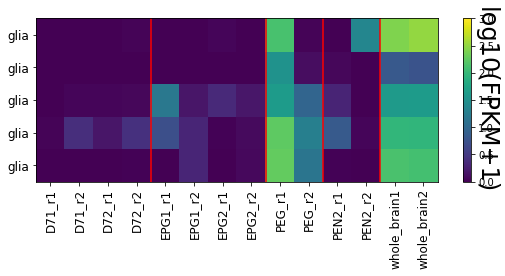

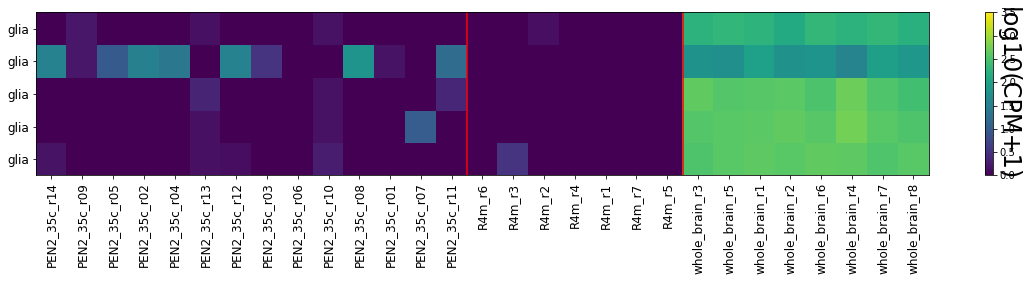

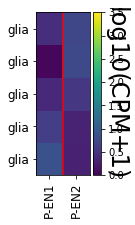

In [39]:
genes2plt = glia
name4plt = 'glia'

pltGenes(genes2plt,name4plt)

#### Look at transmitters

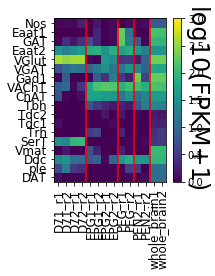

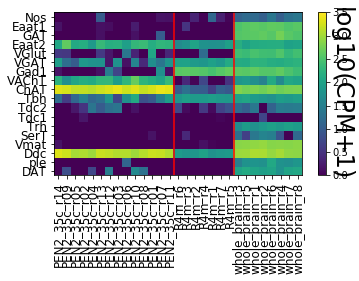

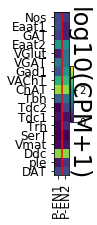

In [40]:
genes2plt = transmitters
name4plt = 'transmitters'

pltGenes(genes2plt,name4plt)

#### Look at receptors - all

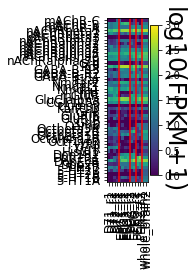

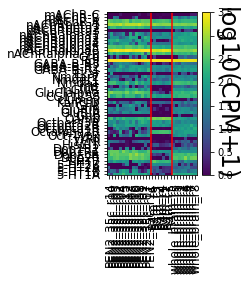

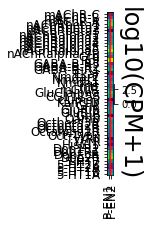

In [41]:
genes2plt = receptors
name4plt = 'receptors'

pltGenes(genes2plt,name4plt)

#### Look at receptors - ACh

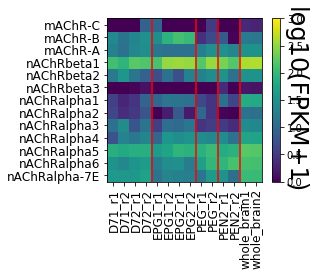

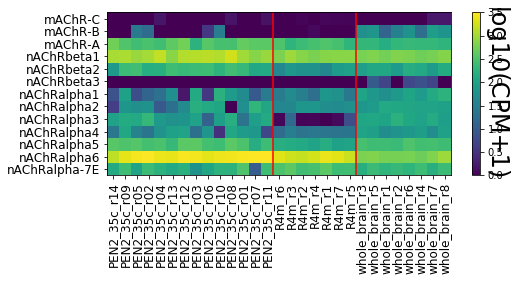

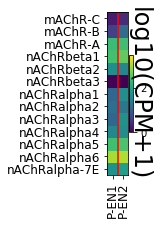

In [42]:
genes2plt = receptors[37:50].reset_index()
name4plt = 'AChReceptors'

pltGenes(genes2plt,name4plt)

#### Look at receptors - glu

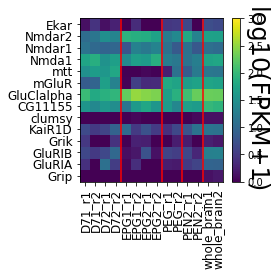

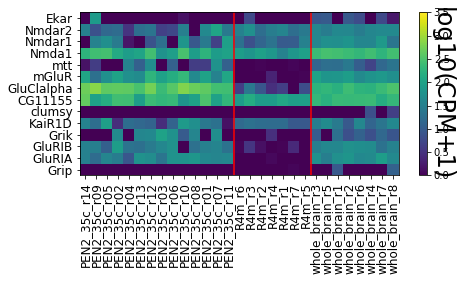

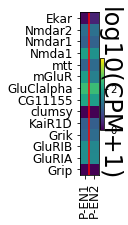

In [43]:
genes2plt = receptors[18:32].reset_index()
name4plt = 'GluReceptors'

pltGenes(genes2plt,name4plt)

#### Look at receptors - GABA

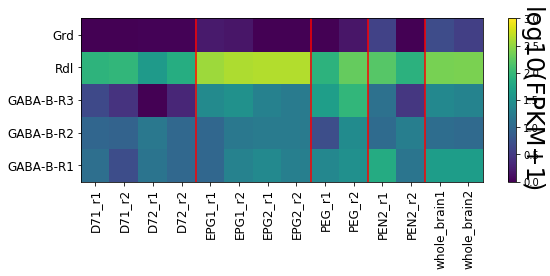

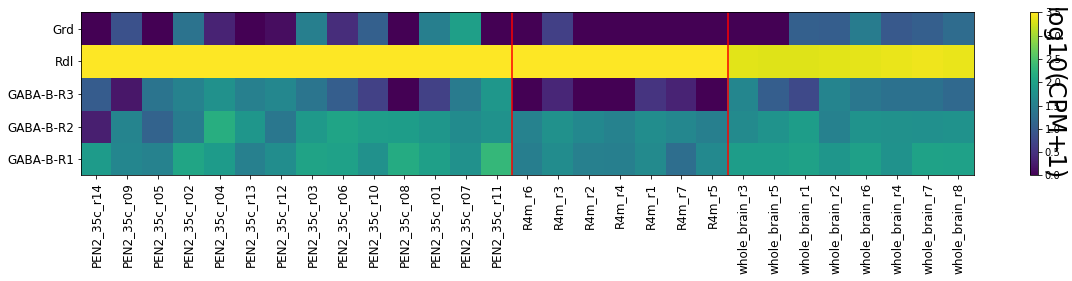

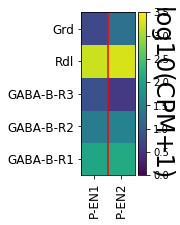

In [44]:
genes2plt = receptors[32:37].reset_index()
name4plt = 'GABAReceptors'

pltGenes(genes2plt,name4plt)

#### Look at receptors - dop

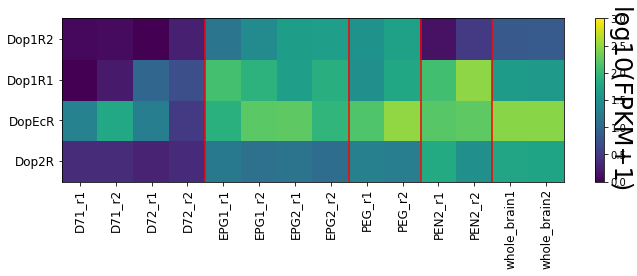

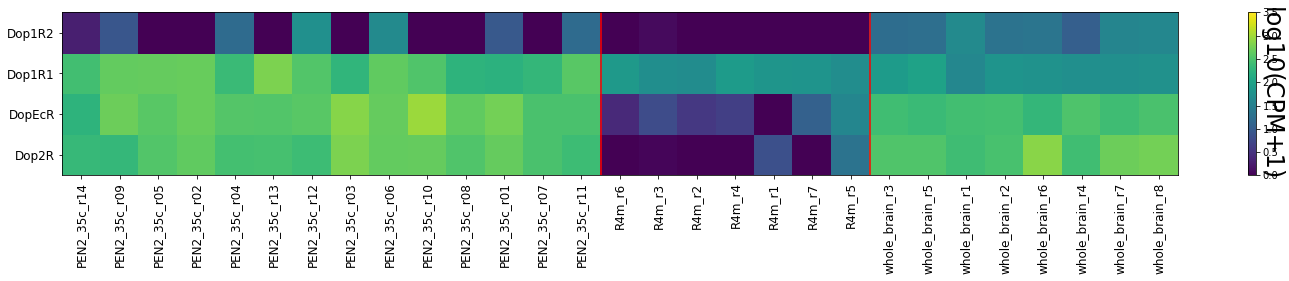

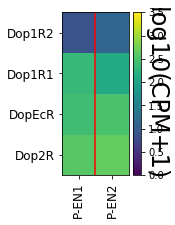

In [45]:
genes2plt = receptors[5:9].reset_index()
name4plt = 'DopReceptors'

pltGenes(genes2plt,name4plt)

#### Look at receptors - oct

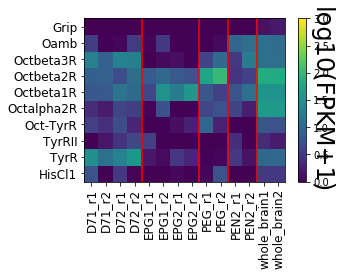

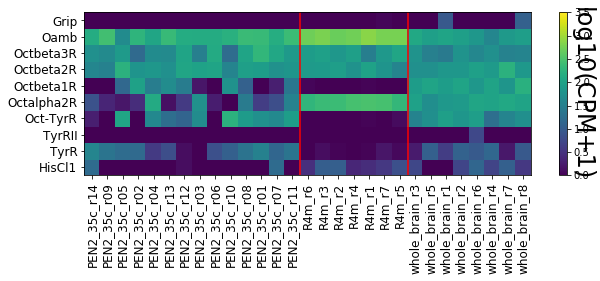

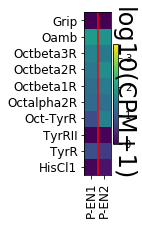

In [46]:
genes2plt = receptors[9:19].reset_index()
name4plt = 'OctReceptors'

pltGenes(genes2plt,name4plt)

#### Look at innexins

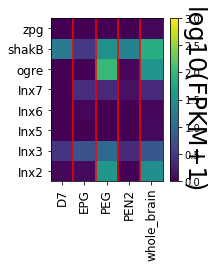

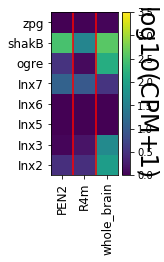

In [47]:
genes2plt = innexins
name4plt = 'innexins'

#pltGenes(genes2plt,name4plt)

bulkMean = pd.DataFrame({
    'gene_id':bulkSeq.iloc[:,0],
    'D7':bulkSeq.iloc[:,1:5].mean(axis = 1),
    'EPG':bulkSeq.iloc[:,5:9].mean(axis = 1),
    'PEG':bulkSeq.iloc[:,9:11].mean(axis = 1),
    'PEN2':bulkSeq.iloc[:,11:13].mean(axis = 1),
    'whole_brain':bulkSeq.iloc[:,13:15].mean(axis = 1)
})
fig = plt.figure(figsize=(2.5,3))
rcParams['svg.fonttype'] = 'none'
pltHtMap(genes2plt,bulkMean,'FPKM',3)
plt.axvline(x=1, color = 'r')
plt.axvline(x=2, color = 'r')
plt.axvline(x=3, color = 'r')
plt.axvline(x=4, color = 'r')
plt.show()
fig.savefig("bulk_" + name4plt + "_mean.svg")

lowCellMean = pd.DataFrame({
    'gene_id':lowCellSeq.iloc[:,0],
    'PEN2':lowCellSeq.iloc[:,1:15].mean(axis = 1),
    'R4m':lowCellSeq.iloc[:,15:22].mean(axis = 1),
    'whole_brain':lowCellSeq.iloc[:,22:30].mean(axis = 1)
})
fig = plt.figure(figsize=(1.5,3))
rcParams['svg.fonttype'] = 'none'
pltHtMap(genes2plt,lowCellMean,'CPM',3.5)
plt.axvline(x=1, color = 'r')
plt.axvline(x=2, color = 'r')
plt.show()
fig.savefig("lowCell_" + name4plt + "_mean.svg")

#### Look at voltage gated channels - all

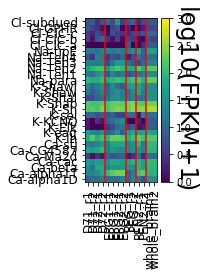

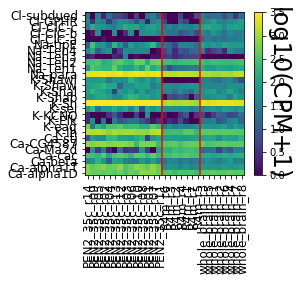

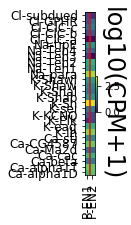

In [48]:
genes2plt = VgatedChannels
name4plt = 'VgatedChannels'

pltGenes(genes2plt,name4plt)

#### Look at voltage gated channels - Ca

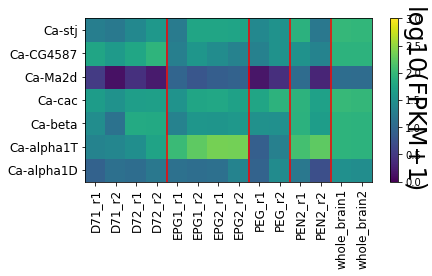

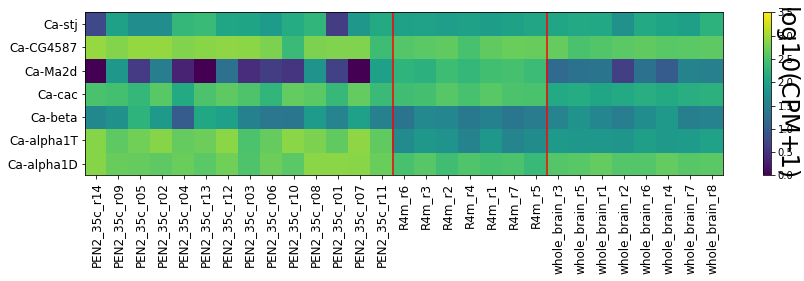

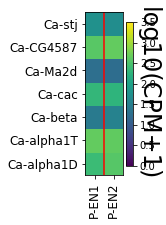

In [49]:
genes2plt = VgatedChannels[0:7].reset_index()
name4plt = 'VgatedChannels_Ca'

pltGenes(genes2plt,name4plt)

#### Look at voltage gated channels - K

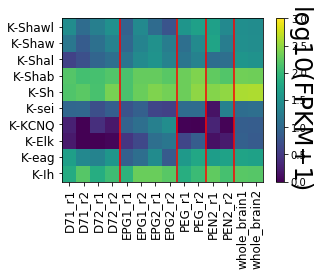

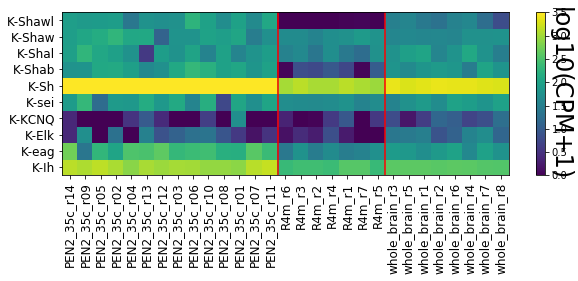

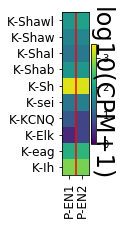

In [50]:
genes2plt = VgatedChannels[7:17].reset_index()
name4plt = 'VgatedChannels_K'

pltGenes(genes2plt,name4plt)

#### Look at voltage gated channels - Na

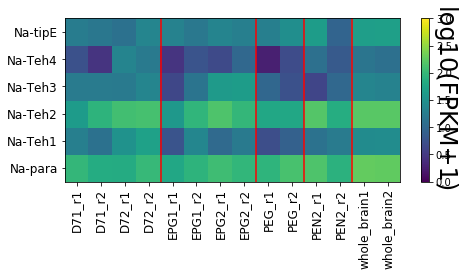

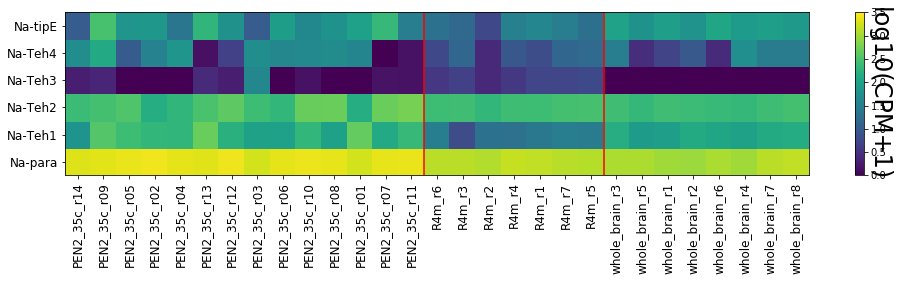

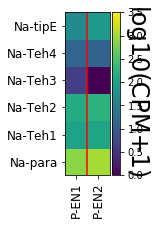

In [51]:
genes2plt = VgatedChannels[17:23].reset_index()
name4plt = 'VgatedChannels_Na'

pltGenes(genes2plt,name4plt)

#### Look at voltage gated channels - Cl

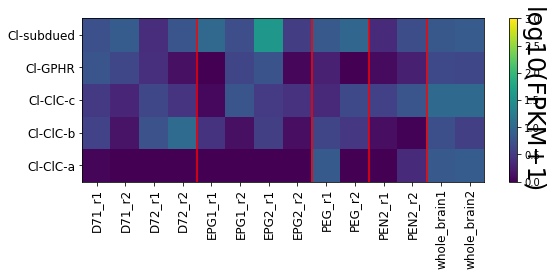

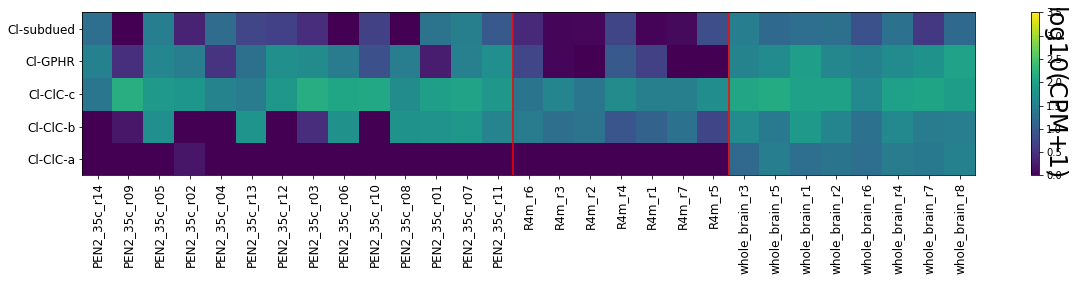

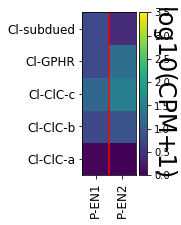

In [52]:
genes2plt = VgatedChannels[23:28].reset_index()
name4plt = 'VgatedChannels_Cl'

pltGenes(genes2plt,name4plt)

#### Look at GPCRs

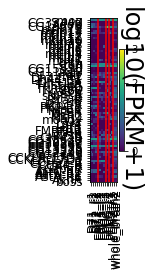

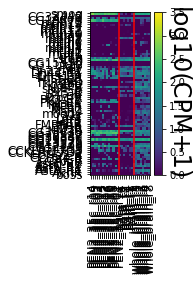

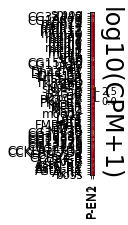

In [53]:
genes2plt = GPCRs
name4plt = 'GPCRs'

pltGenes(genes2plt,name4plt)

#### Look at neuropeptides

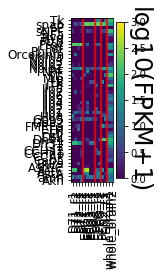

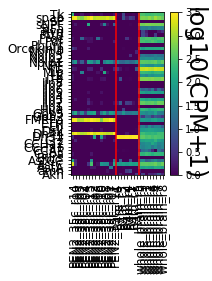

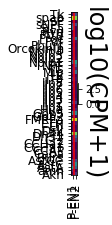

In [54]:
genes2plt = neuropeptides
name4plt = 'neuropeptides'

pltGenes(genes2plt,name4plt)

#### Look at NO receptors

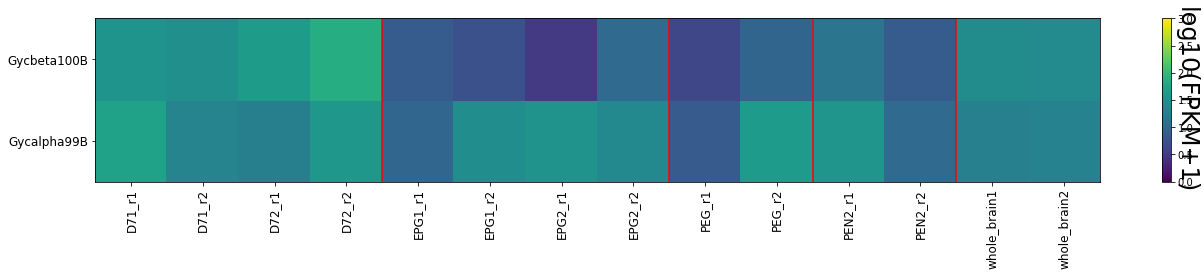

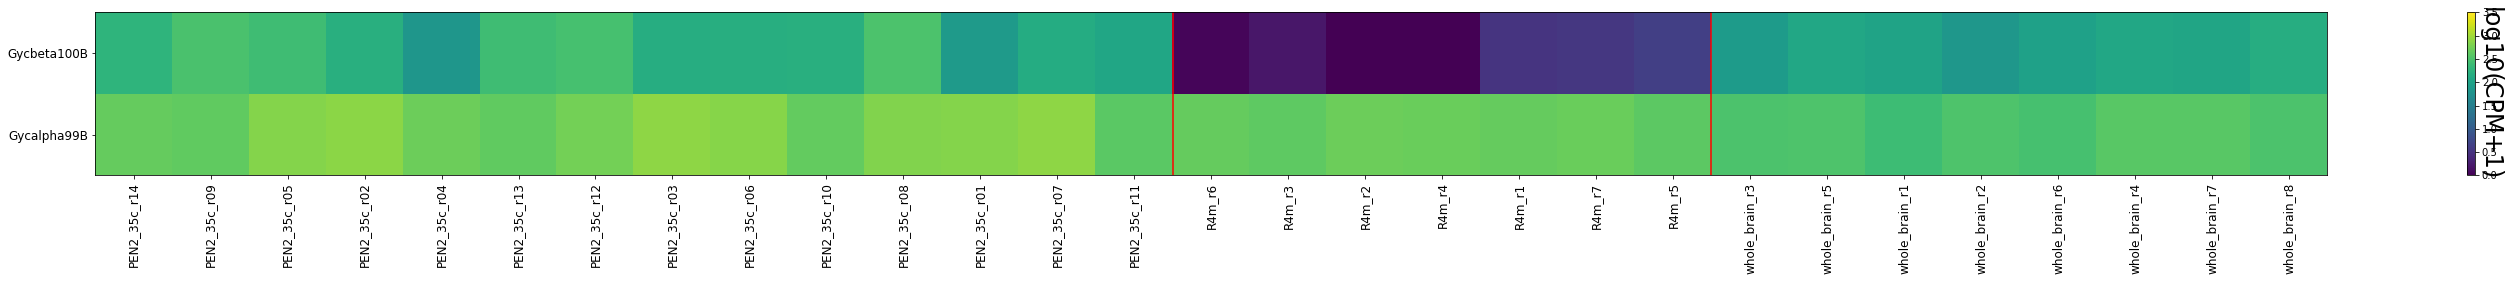

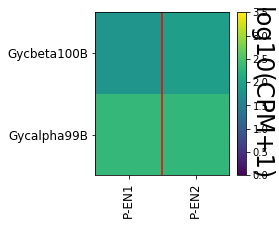

In [55]:
genes2plt = NOreceptors
name4plt = 'NOreceptors'

pltGenes(genes2plt,name4plt)

## Look at the most differentially expressed genes

#### bulk

In [56]:
def names4GenesPVals(dge_table,genesOfInt):
    dge_genes = dge_table['Unnamed: 0']
    dge_pvals = dge_table['PValue']

    geneNames = []
    genePs = []
    for i,gene in enumerate(dge_genes):
        for j,intGene in enumerate(genesOfInt['gene_id']):
            if gene == intGene:
                geneNames.append(genesOfInt['name'][j])
                genePs.append(dge_pvals[i])

    d = {'gene_names': geneNames, 'PValue': genePs}
    return pd.DataFrame(data=d)

In [57]:
dge_table_D7 = pd.read_csv('dge_table_D7_whole.csv',delimiter=',')
dge_table_EPG = pd.read_csv('dge_table_EPG_whole.csv',delimiter=',')
dge_table_PEG = pd.read_csv('dge_table_PEG_whole.csv',delimiter=',')
dge_table_PEN2 = pd.read_csv('dge_table_PEN2_whole.csv',delimiter=',')

genesOfInt = pd.concat([glia,transmitters,receptors,VgatedChannels,innexins,neuropeptides,GPCRs,NOreceptors]).reset_index()

D7PVals = names4GenesPVals(dge_table_D7,genesOfInt)
EPGPVals = names4GenesPVals(dge_table_EPG,genesOfInt)
PEGPVals = names4GenesPVals(dge_table_PEG,genesOfInt)
PEN2PVals = names4GenesPVals(dge_table_PEN2,genesOfInt)

In [58]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(D7PVals)

        gene_names        PValue
0             glia  1.139153e-08
1             glia  4.691251e-08
2            Eaat1  4.691251e-08
3               Tk  9.342724e-08
4              ITP  3.396933e-07
5             Vmat  4.556536e-07
6             glia  1.870985e-06
7            Dop2R  1.941921e-06
8             ogre  2.216104e-06
9             glia  3.303654e-06
10             GAT  3.303654e-06
11              Ms  3.593325e-06
12            sNPF  8.483625e-06
13             Tbh  1.090463e-05
14            AstA  1.606585e-05
15            Inx2  2.361398e-05
16      Octalpha2R  4.775298e-05
17       Octbeta2R  6.862855e-05
18            Dh44  7.913090e-05
19            Gad1  8.890490e-05
20          sNPF-R  1.244903e-04
21     nAChRalpha1  1.343862e-04
22            Ilp6  1.459393e-04
23           VAChT  1.550554e-04
24             DAT  2.067475e-04
25            Ilp2  2.107720e-04
26          5-HT2A  2.118990e-04
27      nAChRbeta1  2.230639e-04
28             Pdf  2.308954e-04
29     nAC

In [59]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(EPGPVals)

        gene_names        PValue
0             glia  3.090070e-08
1              ITP  1.573052e-06
2             glia  1.737209e-06
3            Eaat1  1.737209e-06
4             ogre  6.572695e-06
5               Ms  1.507020e-05
6             Inx2  2.237757e-05
7             Dh44  2.465664e-05
8             sNPF  3.811822e-05
9        Octbeta2R  4.187499e-05
10             mtt  4.986195e-05
11             ple  5.204697e-05
12              Tk  5.530454e-05
13             DAT  6.296317e-05
14            glia  7.021747e-05
15             GAT  7.021747e-05
16           mGluR  7.331410e-05
17           shakB  7.888786e-05
18   nAChRalpha-7E  8.171040e-05
19          Tkr86C  1.095384e-04
20            Vmat  1.115012e-04
21          5-HT1A  1.184925e-04
22        Cl-ClC-a  1.405048e-04
23     nAChRalpha6  1.718700e-04
24          Proc-R  1.722537e-04
25     nAChRalpha1  1.730736e-04
26       Octbeta3R  1.741200e-04
27           Dop2R  3.336449e-04
28             Ddc  4.755781e-04
29        

In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(PEGPVals)

        gene_names    PValue
0               Ms  0.000039
1             sNPF  0.000042
2            VGlut  0.000048
3             Gad1  0.000054
4             Vmat  0.000079
5             Dh31  0.000133
6      nAChRalpha1  0.000225
7             AstC  0.000507
8              Tbh  0.000663
9            Nplp1  0.000921
10       Orcokinin  0.000937
11            TyrR  0.000944
12          K-KCNQ  0.001028
13             DAT  0.001044
14         AstC-R1  0.001051
15          Dh31-R  0.001058
16          5-HT2A  0.001144
17            Oamb  0.001160
18             Pdf  0.001186
19            MsR1  0.001198
20            Dh44  0.001224
21             Dsk  0.001234
22      Octalpha2R  0.001250
23             Hug  0.001280
24     nAChRalpha3  0.001408
25       Octbeta1R  0.001443
26         AstA-R1  0.001480
27            Ilp5  0.001685
28             NPF  0.001868
29             Nos  0.001878
30             Crz  0.002368
31             Mip  0.002483
32             Akh  0.002505
33            

In [61]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(PEN2PVals)

        gene_names    PValue
0             glia  0.000027
1            Eaat1  0.000027
2             Vmat  0.000043
3             sNPF  0.000128
4             Proc  0.000202
5             ogre  0.000230
6        Octbeta2R  0.000254
7             Inx2  0.000386
8              ITP  0.000487
9             Dh31  0.000716
10          CG4313  0.000915
11     nAChRalpha2  0.000946
12          FMRFaR  0.001054
13        Oct-TyrR  0.001098
14      CCKLR-17D1  0.001124
15         AstC-R2  0.001282
16             Nos  0.001464
17          Tkr86C  0.001503
18            glia  0.001535
19             DAT  0.001590
20            Ilp2  0.001724
21       Orcokinin  0.001782
22     nAChRalpha3  0.001832
23            glia  0.001930
24           VGlut  0.001958
25         CG13579  0.002084
26             Pdf  0.002131
27             Dsk  0.002136
28      Octalpha2R  0.002326
29            Ilp5  0.002674
30             NPF  0.003020
31           K-Elk  0.003269
32            Ilp1  0.003359
33            

#### low cell

In [62]:
dge_table_SS00238 = pd.read_csv('dge_table_SS00238_X50pg.csv',delimiter=',')
dge_table_SS02232 = pd.read_csv('dge_table_SS02232_X50pg.csv',delimiter=',')

genesOfInt = pd.concat([glia,transmitters,receptors,VgatedChannels,innexins,neuropeptides,GPCRs,NOreceptors]).reset_index()

SS00238PVals = names4GenesPVals(dge_table_SS00238,genesOfInt)
SS02232PVals = names4GenesPVals(dge_table_SS02232,genesOfInt)

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(SS00238PVals)

        gene_names        PValue
0             Vmat  1.095872e-23
1             sNPF  2.002447e-23
2             Dh31  3.423291e-21
3              Mip  1.770457e-19
4              Rdl  1.858847e-19
5             glia  2.197701e-18
6             Dh44  3.540141e-18
7             glia  3.903612e-18
8            Eaat1  3.903612e-18
9             ChAT  6.180962e-18
10              Ms  6.344833e-18
11       Orcokinin  1.573124e-17
12            Proc  3.717752e-17
13             Ddc  4.688377e-17
14             ITP  8.724722e-17
15            AstA  1.874510e-16
16            spab  1.129923e-15
17            glia  1.325900e-15
18             GAT  1.325900e-15
19              Tk  1.634809e-15
20             Dsk  1.989618e-15
21            glia  5.694532e-15
22       Octbeta1R  6.785129e-15
23            Ilp2  7.016337e-15
24            ogre  9.249744e-15
25             Pdf  1.073238e-14
26            Oamb  1.335466e-14
27            Capa  2.494192e-14
28             Hug  5.577135e-14
29     nAC

In [64]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(SS02232PVals)

        gene_names        PValue
0             Vmat  1.576204e-28
1              ITP  4.732474e-26
2               Ms  2.615357e-25
3             glia  3.634330e-23
4            Eaat1  3.634330e-23
5             Ilp2  6.522308e-22
6              Pdf  6.941629e-21
7             glia  9.847291e-21
8              Hug  2.325803e-20
9             Capa  1.135094e-19
10            glia  4.993628e-19
11            Dh44  1.349657e-16
12            Ilp3  3.566355e-16
13            Ilp5  1.116192e-15
14           FMRFa  1.309667e-15
15             Dsk  2.324534e-15
16            glia  7.075210e-15
17             GAT  7.075210e-15
18      Ca-alpha1T  1.965398e-14
19             Crz  3.662658e-14
20              Lk  5.657711e-14
21            ChAT  7.607362e-14
22     nAChRalpha6  8.161434e-14
23       Orcokinin  1.163623e-13
24            K-Sh  1.848747e-11
25            K-Ih  1.865875e-11
26            Inx3  1.886399e-11
27         CG33639  3.306754e-11
28            Proc  1.218554e-10
29        

### Plot the p values
1. Put all the p values into one matrix
2. Determine if the sample counts are greater than or less than the bulk counts
3. Plot the log 10 of the p values, flipping the sign of those where the counts are higher

In [65]:
# Merge the p values into one data frame
combPVals = pd.DataFrame({'gene_names':EPGPVals['gene_names']})
combPVals = pd.merge(combPVals,EPGPVals,on='gene_names')
combPVals = combPVals.rename(columns = {"PValue":"PValue - EPG"})
combPVals = pd.merge(combPVals,D7PVals,on='gene_names')
combPVals = combPVals.rename(columns = {"PValue":"PValue - D7"})
combPVals = pd.merge(combPVals,PEGPVals,on='gene_names')
combPVals = combPVals.rename(columns = {"PValue":"PValue - PEG"})
combPVals = pd.merge(combPVals,PEN2PVals,on='gene_names')
combPVals = combPVals.rename(columns = {"PValue":"PValue - PEN2"})
combPVals = pd.merge(combPVals,SS02232PVals,on='gene_names')
combPVals = combPVals.rename(columns = {"PValue":"PValue - PEN2_lc"})
combPVals = pd.merge(combPVals,SS00238PVals,on='gene_names')
combPVals = combPVals.rename(columns = {"PValue":"PValue - R4m_lc"})

# Find the mean expression values across samples
# bulk
D7MeanVals = bulkSeq.iloc[:,1:5].mean(axis=1)
EPGMeanVals = bulkSeq.iloc[:,5:9].mean(axis=1)
PEGMeanVals = bulkSeq.iloc[:,9:11].mean(axis=1)
PEN2MeanVals = bulkSeq.iloc[:,11:13].mean(axis=1)
WBMeanVals = bulkSeq.iloc[:,13:15].mean(axis=1)
ctDiffsBulk = pd.DataFrame({'EPGDiff':(EPGMeanVals-WBMeanVals),
                        'D7Diff':(D7MeanVals-WBMeanVals),
                        'PEGDiff':(PEGMeanVals-WBMeanVals),
                        'PEN2Diff':(PEN2MeanVals-WBMeanVals)
                       })
ctDiffsBulk[ctDiffsBulk >= 0] = 0
ctDiffsBulk[ctDiffsBulk < 0] = 1
ctDiffsBulk[ctDiffsBulk == 0] = -1
ctDiffsBulk['gene_id'] = bulkSeq['gene_id']

# low cell
PEN2MeanVals_lc = lowCellSeq.iloc[:,1:15].mean(axis=1)
R4mMeanVals_lc = lowCellSeq.iloc[:,15:22].mean(axis=1)
WBMeanVals_lc = lowCellSeq.iloc[:,22:30].mean(axis=1)
ctDiffsLowCell = pd.DataFrame({'R4mDiff_lc':(R4mMeanVals_lc-WBMeanVals_lc),
                        'PEN2Diff_lc':(PEN2MeanVals_lc-WBMeanVals_lc)
                       })
ctDiffsLowCell[ctDiffsLowCell >= 0] = 0
ctDiffsLowCell[ctDiffsLowCell < 0] = 1
ctDiffsLowCell[ctDiffsLowCell == 0] = -1
ctDiffsLowCell['gene_id'] = lowCellSeq['gene_id']

# Use the differences to create a signed dataframe
ctDiffs = pd.merge(ctDiffsBulk,ctDiffsLowCell,on='gene_id')


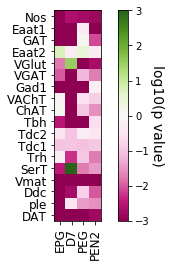

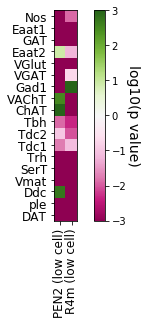

In [69]:
from matplotlib import colors

# Specify the genese to consider
geneNm = 'transmitters'
genesToConsider = transmitters

# Select those values from the p value and signed data frames
combDat = genesToConsider.rename(columns={'name':'gene_names'})
combDat = pd.merge(combDat,combPVals,on='gene_names')
combDat = pd.merge(combDat,ctDiffs,on='gene_id')

# Manipulate the data for plotting
pltDat = pd.DataFrame({'gene_names':combDat['gene_names'],
                       'EPG':(np.log10(combDat['PValue - EPG'])*combDat['EPGDiff']),
                       'D7':(np.log10(combDat['PValue - D7'])*combDat['D7Diff']),
                       'PEG':(np.log10(combDat['PValue - PEG'])*combDat['PEGDiff']),
                       'PEN2':(np.log10(combDat['PValue - PEN2'])*combDat['PEN2Diff']),
                       'PEN2 (low cell)':(np.log10(combDat['PValue - PEN2_lc'])*combDat['PEN2Diff_lc']),
                       'R4m (low cell)':(np.log10(combDat['PValue - R4m_lc'])*combDat['R4mDiff_lc']),
                      })

# Plot the bulk data
fig = plt.figure()
rcParams['svg.fonttype'] = 'none'
pc = plt.pcolor(pltDat.iloc[:,1:5],vmin=-3,vmax=3,cmap='PiYG',
               norm = colors.DivergingNorm(vmin=-3., vcenter=0., vmax=3))

plt.xticks(np.arange(0.5, 4.5, 1), pltDat.columns[1:5],fontsize = 12,rotation=90)
plt.yticks(np.arange(0.5, len(genesToConsider)), genesToConsider["name"],fontsize = 12)

cbar = plt.colorbar(pc)
cbar.set_label('log10(p value)', rotation=270,size=14,labelpad=14)

plt.gcf().subplots_adjust(bottom=0.15)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

fig.savefig("plots//" + geneNm + "PVals_bulk.svg")

# Plot the low cell data
fig = plt.figure()
rcParams['svg.fonttype'] = 'none'
pc = plt.pcolor(pltDat.iloc[:,5:7],vmin=-3,vmax=3,cmap='PiYG',
               norm = colors.DivergingNorm(vmin=-3., vcenter=0., vmax=3))

plt.xticks(np.arange(0.5, 2.5, 1), pltDat.columns[5:7],fontsize = 12,rotation=90)
plt.yticks(np.arange(0.5, len(genesToConsider)), genesToConsider["name"],fontsize = 12)

cbar = plt.colorbar(pc)
cbar.set_label('log10(p value)', rotation=270,size=14,labelpad=14)

plt.gcf().subplots_adjust(bottom=0.15)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

fig.savefig("plots//" + geneNm + "PVals_lowCell.svg")